
## LSTM and BiLSTM + Attention Implementation

### Date: 08/05/2025

### contributor : Swathi Subramanyam Pabbathi

This notebook includes data preparation, exploratory data analysis (EDA), data preprocessing, feature extraction, and the implementation of multiple deep learning models: LSTM and Bidirectional LSTM with Attention.

For each model, we performed model building, training, evaluation, and hyperparameter tuning using grid search to identify the optimal configuration. The final versions of the models were saved as:

*	final_lstm_model.keras

*	final_bi_lstm_attention_model

featured datasets train, val and test for further analysis and testing are placed in featured_datasets folder /featured_datasets

Requirements: We used an AWS SageMaker ml.g4dn.xlarge instance to train and fine-tune the LSTM and Bidirectional LSTM + Attention models. The workspace required approximately 20 GB of storage for managing the MIDI dataset, processed feature files, and model checkpoints during training and evaluation.

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs: []


### Import all the necessary libraries

In [4]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame
import math
from tqdm import tqdm

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/opt/anaconda3/envs/composer-env/lib/python3.11/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


pygame 2.6.1 (SDL 2.32.54, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Data loading and preparation

In [13]:
# Set up and collect all MIDI file paths
import os
from glob import glob

# Root directory with composer folders
root_dir = "selectedcomposers"

# Filter only valid composers
VALID_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Get all composer folders
composer_dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Map: composer > list of MIDI file paths
composer_to_files = {
    composer: glob(os.path.join(root_dir, composer, "**", "*.mid")) 
    for composer in composer_dirs
}

### Train, Val and Test data split

I wanted to split the train, val and test before feature extraction to avoid any data leakage while extracting global features on composer+file+program level not only on chunk level and frequency encode on features such as program(i.e.,instrument type)

In [14]:
# Split each composer’s MIDI files into train/val/test
from sklearn.model_selection import train_test_split

train_files, val_files, test_files = [], [], []

for composer, files in composer_to_files.items():
    if len(files) < 3:
        print(f"Skipping {composer} — not enough files: {len(files)}")
        continue  # Skip this composer

    # 70% train, 15% val, 15% test
    train, temp = train_test_split(files, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_files.extend(train)
    val_files.extend(val)
    test_files.extend(test)

print(f"# Train MIDI files: {len(train_files)}")
print(f"# Val MIDI files: {len(val_files)}")
print(f"# Test MIDI files: {len(test_files)}")

Skipping Chopin — not enough files: 0
# Train MIDI files: 672
# Val MIDI files: 144
# Test MIDI files: 146


### Label encoding the target variale to 0, 1, 2 and 3 rather than text

In [15]:
# Map composers to numeric class IDs
composer_list = VALID_COMPOSERS  # Already filtered
composer_to_id = {name: idx for idx, name in enumerate(composer_list)}

print("\n Composers:", composer_list)
print("Composer to ID mapping:", composer_to_id)


 Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
Composer to ID mapping: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}


### Note level feature extraction 

Below are the features extracted for the classification task on composers,

The function extract_note_features() is designed to extract structured features from MIDI files for use in machine learning tasks such as composer classification.

1.	Tempo Extraction: The function estimates the overall tempo of the MIDI file.

2.	Instrument Loop:Iterates through all non-drum instruments in the MIDI file.

3.	Note Sorting and Chunking:Sorts notes by start time and breaks them into non-overlapping chunks of a given size (default: 200 notes).

4.	Chunk-Level Feature Calculation:For each chunk, it computes aggregate musical features that describe the overall structure and behavior of the notes in that chunk.

5.	Per-Note Feature Extraction:For each note in a chunk, it extracts time-based and pitch-based features and annotates them with the chunk-level statistics.

6.	Feature Aggregation:The result is a list of dictionaries, each representing a single note with both per-note and chunk-level musical attributes, along with composer metadata.


| Feature           | Description                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `Pitch`           | The MIDI pitch number (0–127) of the note.                                  |
| `Duration`        | The time the note is held (end time - start time).                          |
| `Velocity`        | The intensity/loudness of the note (0–127).                                 |
| `DeltaTime`       | Time difference between the current and previous note's start time.         |
| `Start`           | Start time of the note in seconds.                                          |
| `End`             | End time of the note in seconds.                                            |
| `Interval`        | Difference in pitch from the previous note.                                 |
| `Program`         | MIDI program number representing the instrument used.                       |
| `Accented`        | Binary flag indicating whether the note is played loudly (velocity > 80).   |
| `Composer`        | The name of the composer associated with the MIDI file.                     |
| `ComposerID`      | Numeric class ID for the composer (used for classification).                |
| `Tempo`           | Estimated global tempo (beats per minute) of the MIDI file.                 |
| `PitchRange`      | Difference between the highest and lowest pitch in the note chunk.          |
| `NoteDensity`     | Number of notes per second within the chunk.                                |
| `RepetitionRate`  | Proportion of notes that have the same pitch as their immediate predecessor.|
| `AvgInterval`     | Average pitch interval between consecutive notes in the chunk.              |
| `RhythmicVariety` | Standard deviation of note durations in the chunk (indicates rhythm complexity). |
| `ChordDensity`    | Fraction of notes that overlap with the previous note (indicates harmony/chords). |



In [16]:
def extract_note_features(midi, composer, composer_id, chunk_size=100):
    features = []

    # Extract global tempo
    try:
        tempo = midi.estimate_tempo()
    except:
        tempo = 120.0  # fallback tempo

    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        instrument_program = instrument.program
        notes = sorted(instrument.notes, key=lambda n: n.start)

        if len(notes) < chunk_size:
            continue  # skip short instruments

        # Chunk the notes (non-overlapping)
        for i in range(0, len(notes) - chunk_size + 1, chunk_size):
            chunk = notes[i:i+chunk_size]
            chunk_start = chunk[0].start
            chunk_end = chunk[-1].end
            chunk_duration = chunk_end - chunk_start

            # ---- Higher-level stats ----
            pitches = [n.pitch for n in chunk]
            durations = [n.end - n.start for n in chunk]
            velocities = [n.velocity for n in chunk]
            intervals = [pitches[i] - pitches[i-1] for i in range(1, len(pitches))]
            starts = [n.start for n in chunk]

            pitch_range = max(pitches) - min(pitches)
            note_density = len(chunk) / (chunk_duration + 1e-6)  # notes/sec
            repetition_rate = sum([1 for i in range(1, len(pitches)) if pitches[i] == pitches[i-1]]) / len(pitches)
            avg_interval = np.mean(intervals) if intervals else 0.0
            rhythmic_variety = np.std(durations)
            chord_density = sum([1 for i in range(1, len(chunk)) if chunk[i].start < chunk[i-1].end]) / len(chunk)

            # ---- Per-note features ----
            prev_start = chunk[0].start
            prev_pitch = chunk[0].pitch

            for note in chunk:
                pitch = note.pitch
                start = note.start
                end = note.end
                duration = end - start
                delta_time = start - prev_start
                velocity = note.velocity
                interval = pitch - prev_pitch
                is_accented = 1 if velocity > 80 else 0

                features.append({
                    "Pitch": pitch,
                    "Duration": duration,
                    "Velocity": velocity,
                    "DeltaTime": delta_time,
                    "Start": start,
                    "End": end,
                    "Interval": interval,
                    "Program": instrument_program,
                    "Accented": is_accented,
                    "Composer": composer,
                    "ComposerID": composer_id,
                    "Tempo": tempo,
                    "PitchRange": pitch_range,
                    "NoteDensity": note_density,
                    "RepetitionRate": repetition_rate,
                    "AvgInterval": avg_interval,
                    "RhythmicVariety": rhythmic_variety,
                    "ChordDensity": chord_density
                })

                prev_start = start
                prev_pitch = pitch

    return features

Takes a list of midi_files, a composer_to_id dictionary mapping composer names to numeric IDs, and an optional chunk_size (default = 100 notes). Returns a DataFrame with engineered features extracted from each MIDI file.

In [17]:
import warnings

def extract_features_from_files(midi_files, composer_to_id, chunk_size=100):
    all_features = []

    for path in midi_files:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)

                midi = pretty_midi.PrettyMIDI(path)

            composer = os.path.basename(os.path.dirname(path))
            composer_id = composer_to_id[composer]

            feats = extract_note_features(midi, composer, composer_id, chunk_size)
            all_features.extend(feats)

        except Exception as e:
            print(f"Skipped {path}: {e}")
    
    return pd.DataFrame(all_features)

In [18]:
# Extract the features separately on all train,val and test datasets
df_train = extract_features_from_files(train_files, composer_to_id, chunk_size=100)
df_val   = extract_features_from_files(val_files, composer_to_id, chunk_size=100)
df_test  = extract_features_from_files(test_files, composer_to_id, chunk_size=100)

Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/041400b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/026100b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/Bwv028.6.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/011704v1.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/033700b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv1080 The Art Of Fugue/Canon Fugue n1.mid: 'Bwv1080 The Art Of Fugue'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/037400b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/026000b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/019707ba.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/018707b_.mid: 'Bwv001- 400 Chorales'
Skipped selectedcomposers/Bach/Bwv001- 400 Chorales/040400bv.mid: 'Bwv001- 400 Chorales'
Skipped

KeyboardInterrupt: 

In [13]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1083900, 18)
(218200, 18)
(277300, 18)


In [23]:
import os

# Define the output folder path (one level up from notebook)
output_dir = os.path.join("..", "featured_datasets")

# Create the folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the files in the specified folder
df_train.to_csv(os.path.join(output_dir, "composer_train_features.csv"), index=False)
df_val.to_csv(os.path.join(output_dir, "composer_val_features.csv"), index=False)
df_test.to_csv(os.path.join(output_dir, "composer_test_features.csv"), index=False)

print("CSV files saved to:", output_dir)

CSV files saved to: ../featured_datasets


In [24]:
# Drop only the 'Composer' column from original datasets
df_train.drop(columns=['Composer'], inplace=True, errors='ignore')
df_val.drop(columns=['Composer'], inplace=True, errors='ignore')
df_test.drop(columns=['Composer'], inplace=True, errors='ignore')

# Show sample rows
print("Train Set Sample:")
display(df_train.head())

print("Validation Set Sample:")
display(df_val.head())

print("Test Set Sample:")
display(df_test.head())

Train Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,88,0.115384,92,0.000000,0.230769,0.346153,0,73,1,0,247.716121,27,0.862823,0.01,0.020202,0.04628,0.0
1,87,0.115385,92,0.115384,0.346153,0.461538,-1,73,1,0,247.716121,27,0.862823,0.01,0.020202,0.04628,0.0
2,88,0.076923,92,0.115385,0.461538,0.538461,1,73,1,0,247.716121,27,0.862823,0.01,0.020202,0.04628,0.0
3,83,0.076923,92,0.230769,0.692307,0.769230,-5,73,1,0,247.716121,27,0.862823,0.01,0.020202,0.04628,0.0
4,80,0.076923,92,0.230769,0.923076,0.999999,-3,73,1,0,247.716121,27,0.862823,0.01,0.020202,0.04628,0.0


Validation Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,71,0.150,127,0.00,0.30,0.450,0,0,1,0,199.340779,19,5.747126,0.05,0.0,0.053012,0.0
1,70,0.150,127,0.15,0.45,0.600,-1,0,1,0,199.340779,19,5.747126,0.05,0.0,0.053012,0.0
2,71,0.150,127,0.15,0.60,0.750,1,0,1,0,199.340779,19,5.747126,0.05,0.0,0.053012,0.0
3,66,0.150,127,0.30,0.90,1.050,-5,0,1,0,199.340779,19,5.747126,0.05,0.0,0.053012,0.0
4,67,0.075,127,0.30,1.20,1.275,1,0,1,0,199.340779,19,5.747126,0.05,0.0,0.053012,0.0


Test Set Sample:


,Pitch,Duration,Velocity,DeltaTime,Start,End,Interval,Program,Accented,ComposerID,Tempo,PitchRange,NoteDensity,RepetitionRate,AvgInterval,RhythmicVariety,ChordDensity
0,81,1.397261,107,0.000000,3.698631,5.095892,0,0,1,0,291.738193,26,4.4323,0.0,-0.171717,0.474297,0.3
1,76,1.150685,107,0.410959,4.109590,5.260275,-5,0,1,0,291.738193,26,4.4323,0.0,-0.171717,0.474297,0.3
2,73,0.945206,107,0.205479,4.315069,5.260275,-3,0,1,0,291.738193,26,4.4323,0.0,-0.171717,0.474297,0.3
3,69,0.328767,107,0.616439,4.931508,5.260275,-4,0,1,0,291.738193,26,4.4323,0.0,-0.171717,0.474297,0.3
4,80,0.164384,107,0.205480,5.136987,5.301371,11,0,1,0,291.738193,26,4.4323,0.0,-0.171717,0.474297,0.3


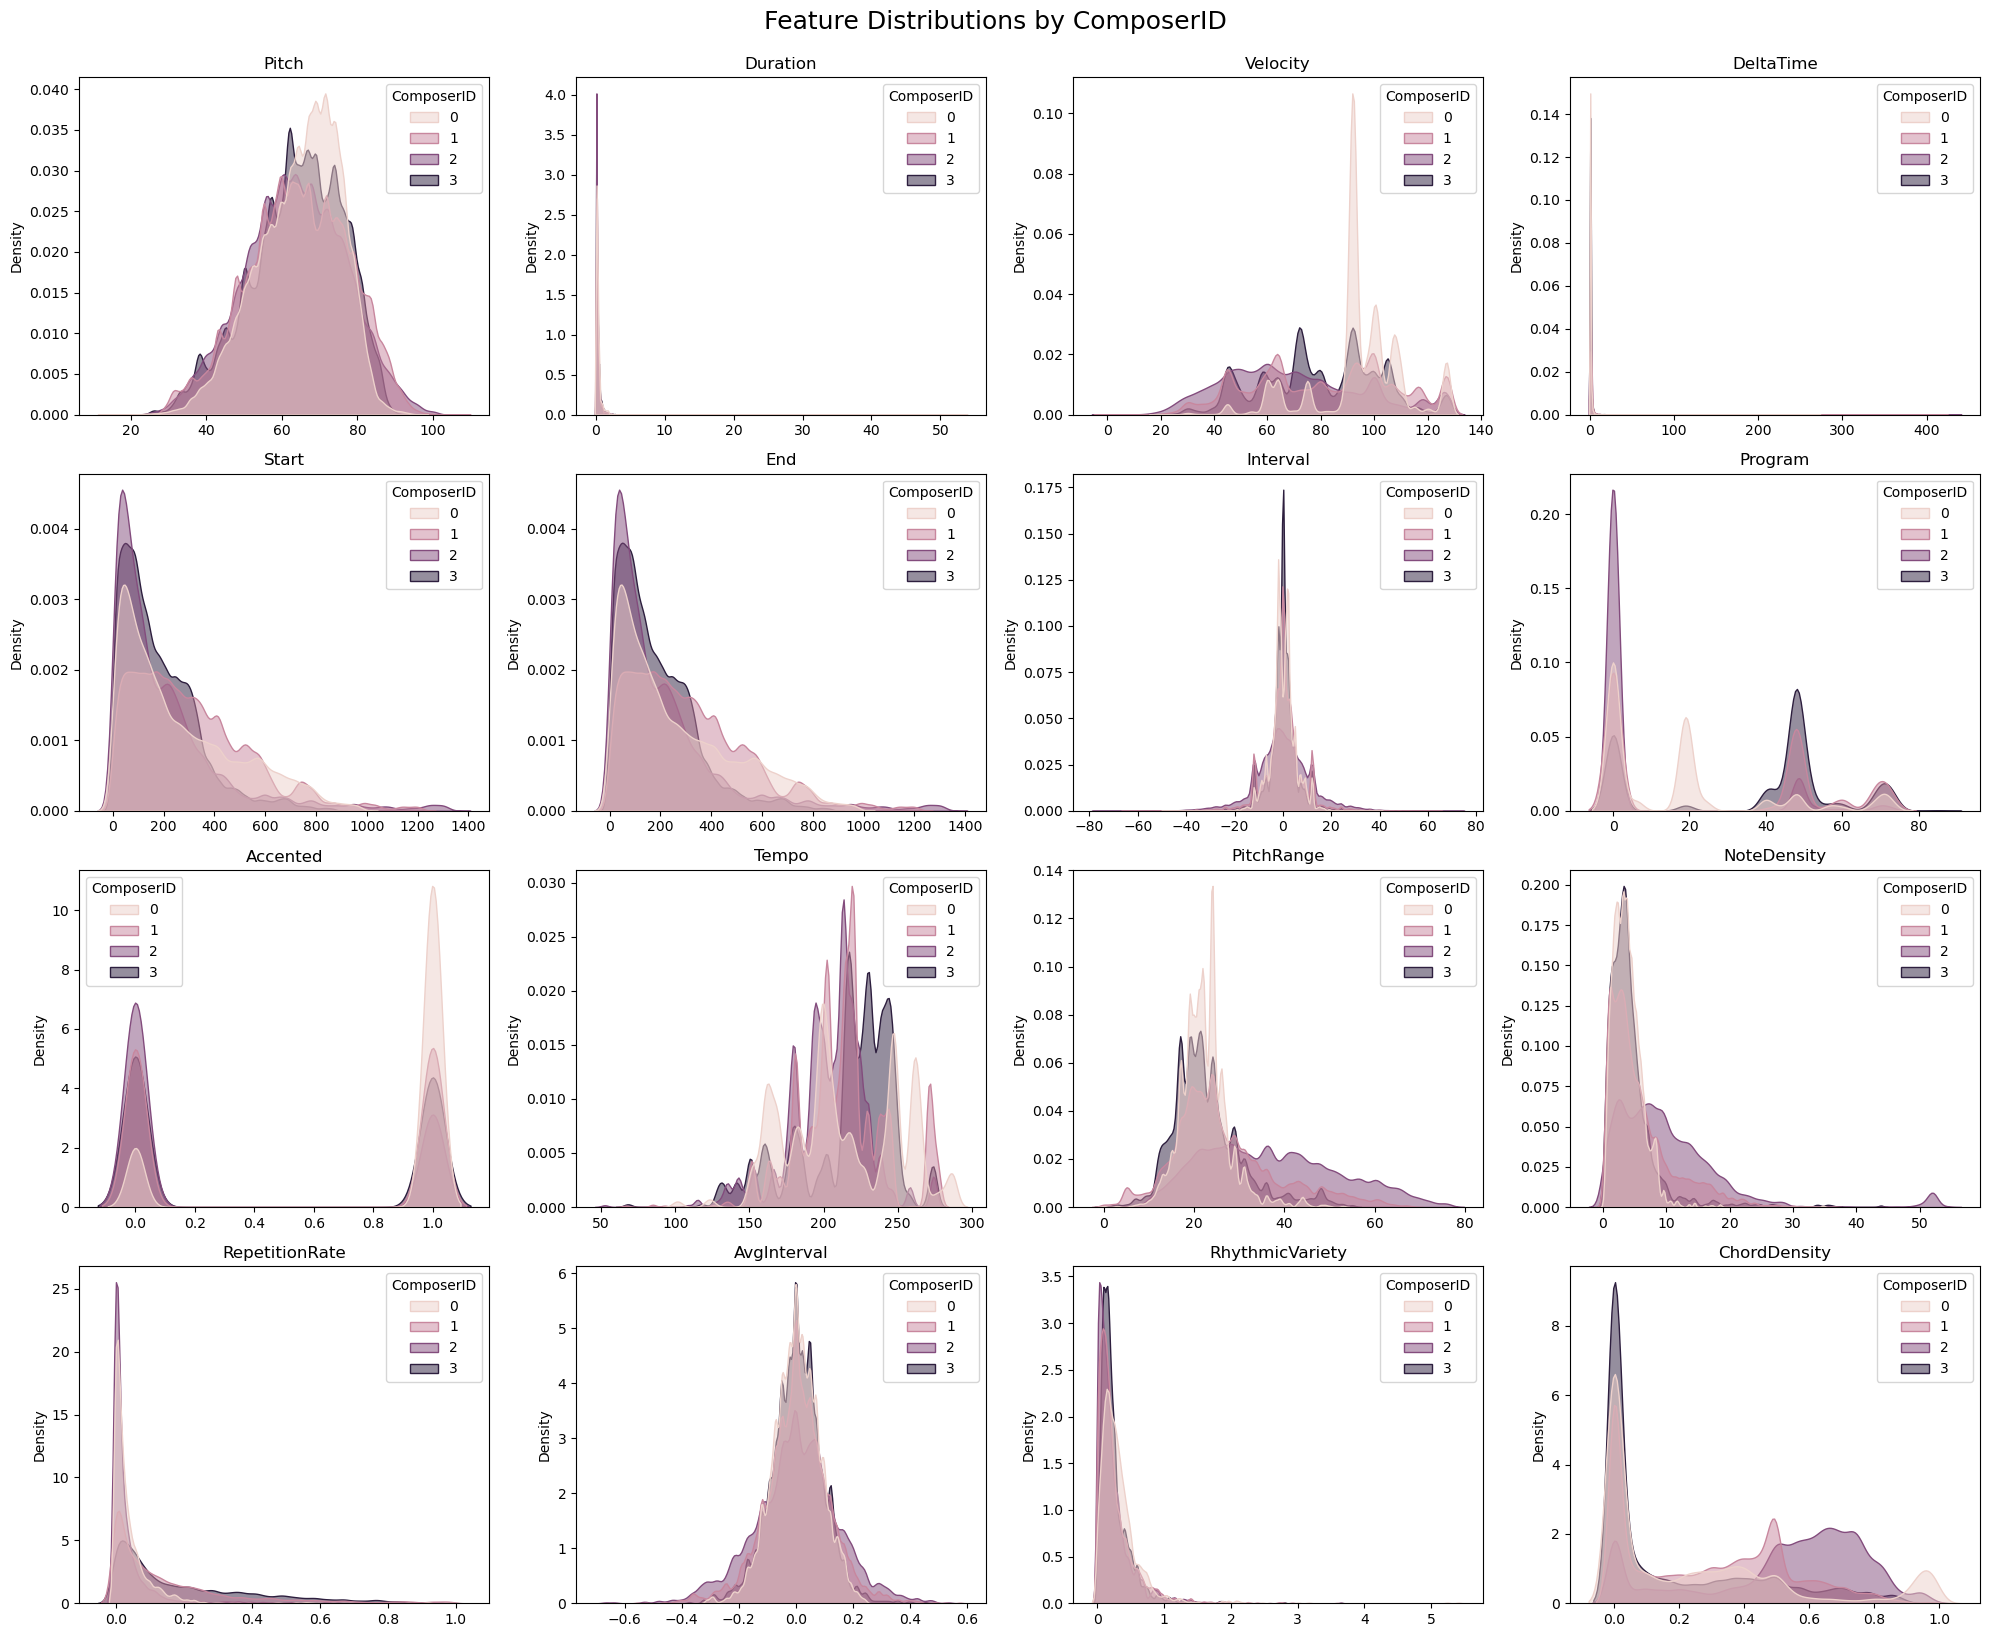

In [22]:
# To plot all features distributions by ComposerID
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns excluding 'ComposerID'
feature_cols = [col for col in df_train.columns if col != 'ComposerID' and df_train[col].dtype != 'object']

# Set up the grid
n_cols = 4
n_rows = (len(feature_cols) + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(20, 4 * n_rows))

for idx, col in enumerate(feature_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.kdeplot(data=df_train, x=col, hue="ComposerID", common_norm=False, fill=True, alpha=0.5)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Density')

plt.tight_layout()
plt.suptitle("Feature Distributions by ComposerID", fontsize=18, y=1.02)
plt.show()

### Feature Distribution Inference by Composer

| Feature        | Inference |
|----------------|-----------|
| **Pitch**      | All composers use pitch ranges ~40–80. **Mozart (3)** tends to favor slightly higher pitches. |
| **Duration**   | **Chopin (2)** has longer note durations, aligning with his expressive legato style. |
| **Velocity**   | **Mozart (3)** has a sharp peak near 80 (consistent dynamics), others show wider variation. |
| **DeltaTime**  | All have sharp spikes at low values (~0–10), with **Bach (0)** showing denser transitions. |
| **Start / End**| Longer tails for **Mozart (3)** and **Beethoven (1)** suggest longer or more complex compositions. |
| **Interval**   | Most notes are step-wise (peak at 0). **Bach (0)** and **Beethoven (1)** show tighter interval control. |
| **Program**    | **Bach (0)** is concentrated in lower program numbers (organ/harpsichord). Others vary more. |
| **Accented**   | **Mozart (3)** and **Chopin (2)** emphasize accented notes more than **Bach (0)**. |
| **Tempo**      | **Chopin (2)** has diverse tempo usage (rubato). **Bach (0)** is more consistent. |
| **PitchRange** | **Mozart (3)** shows a wider melodic range. **Bach (0)** and **Beethoven (1)** are more narrow. |
| **NoteDensity**| **Chopin (2)** has lower density (more spacing). **Bach (0)** and **Beethoven (1)** show denser compositions. |


*   Mozart: Wide pitch and velocity spread, frequent accents, and use of broader pitch ranges.

*	Chopin: Longer note durations, expressive tempo usage, and lower note density—consistent with romantic, lyrical style.

*	Bach: Dense, rhythmically tight compositions with limited dynamic and pitch variation—consistent with baroque polyphony.

*	Beethoven: Transitional mix between classical and romantic, with moderate note density, expressive range, and wider instrument usage.

Class distribution in train dataset:
ComposerID
1    429000
3    228700
0    214400
2    211800
Name: count, dtype: int64


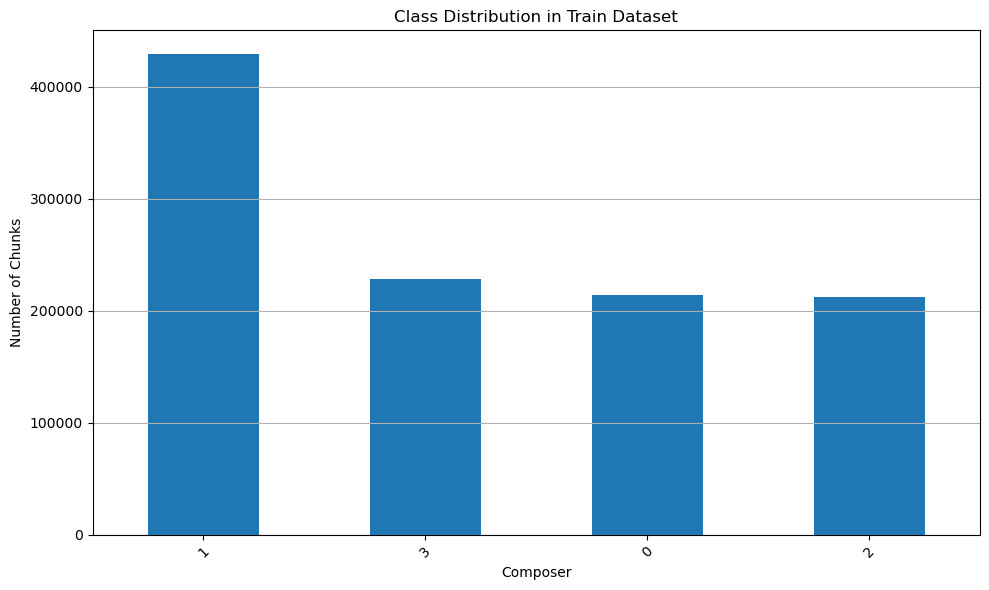

In [25]:
# Class distribution in train dataset
composer_counts = df_train['ComposerID'].value_counts()
print("Class distribution in train dataset:")
print(composer_counts)

# Optional: visualize it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar')
plt.title('Class Distribution in Train Dataset')
plt.xlabel('Composer')
plt.ylabel('Number of Chunks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Frequency of 'Program' in the training set
program_freq = df_train['Program'].value_counts(normalize=True)

# Convert to a dictionary
program_freq_dict = program_freq.to_dict()

### Data Preprocessing - perform Note-Level Data Augmentation (on df_train only)

In [ ]:
# Get class counts
train_counts = df_train['ComposerID'].value_counts()
target_count = train_counts.max()

# Define augmentation function (on a group of notes)
def augment_notes(notes_df):
    df_aug = notes_df.copy()

    # Random parameters
    pitch_shift = np.random.choice([-3, -2, -1, 1, 2, 3])
    duration_scale = np.random.uniform(0.9, 1.1)
    time_shift = np.random.uniform(-0.1, 0.1)

    df_aug['Pitch'] = np.clip(df_aug['Pitch'] + pitch_shift, 0, 127)
    df_aug['Duration'] = df_aug['Duration'] * duration_scale
    df_aug['Start'] = df_aug['Start'] + time_shift
    df_aug['End'] = df_aug['Start'] + df_aug['Duration']
    
    return df_aug


In [ ]:
from sklearn.utils import resample

target_count = df_train['ComposerID'].value_counts().max()
balanced_chunks = []

for composer in df_train['ComposerID'].unique():
    df_c = df_train[df_train['ComposerID'] == composer]
    current_count = len(df_c)
    
    if current_count < target_count:
        needed = target_count - current_count
        # Create note chunks
        note_chunks = [df_c.iloc[i:i+100] for i in range(0, len(df_c)-100, 100)]
        
        for _ in range(needed // 100):
            chunk = resample(note_chunks, n_samples=1)[0]
            augmented = augment_notes(chunk)
            balanced_chunks.append(augmented)

df_train_aug = pd.concat([df_train] + balanced_chunks).reset_index(drop=True)

<Axes: xlabel='ComposerID'>

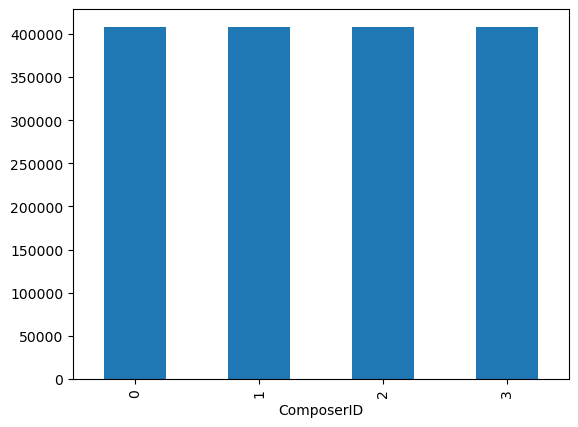

In [ ]:
df_train_aug['ComposerID'].value_counts().plot(kind='bar')

After data augmentation and resampling able to balance the data on train dataset

In [ ]:
df_train['Source'] = 'Original'

# Label each augmented chunk
for chunk in balanced_chunks:
    chunk['Source'] = 'Augmented'

# Combine all augmented chunks
df_augmented = pd.concat(balanced_chunks).reset_index(drop=True)

# Merge for comparison
df_compare = pd.concat([df_train, df_augmented]).reset_index(drop=True)

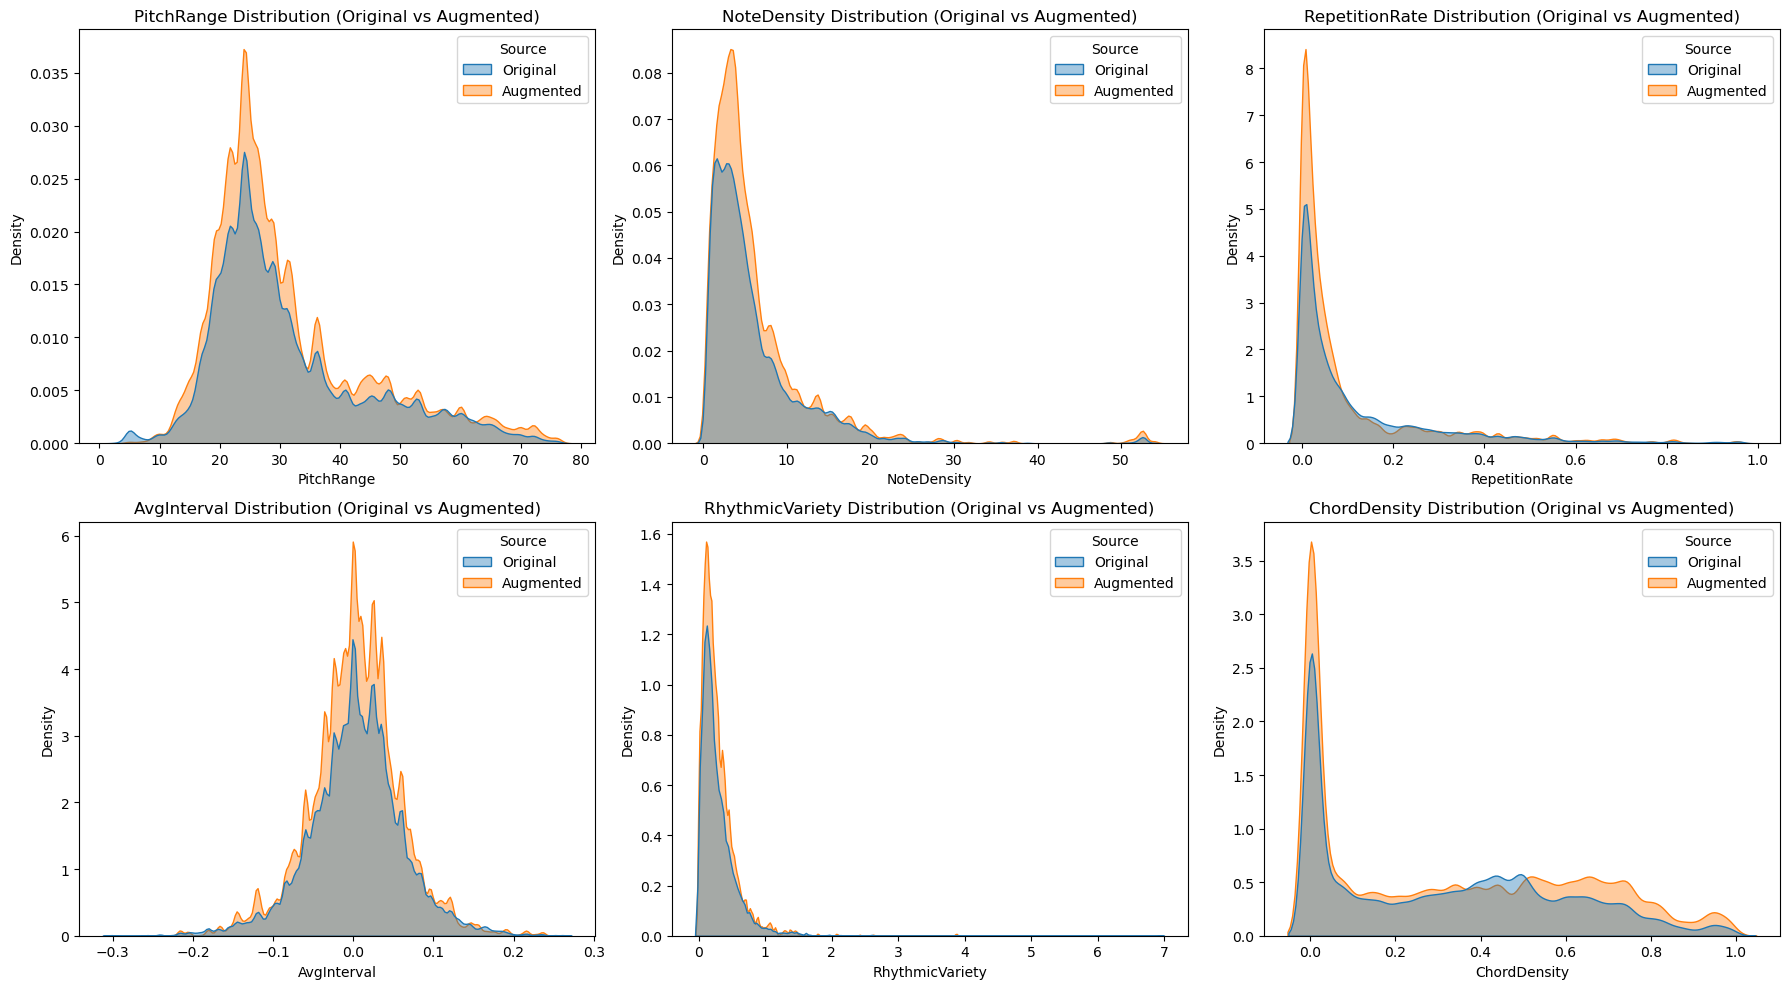

In [ ]:
# Plots to compare original and after augmentations
import seaborn as sns
import matplotlib.pyplot as plt

features = ['PitchRange', 'NoteDensity', 'RepetitionRate', 'AvgInterval', 'RhythmicVariety', 'ChordDensity']

plt.figure(figsize=(18, 10))
for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=df_compare, x=feat, hue='Source', fill=True, alpha=0.4)
    plt.title(f'{feat} Distribution (Original vs Augmented)')

plt.tight_layout()
plt.show()

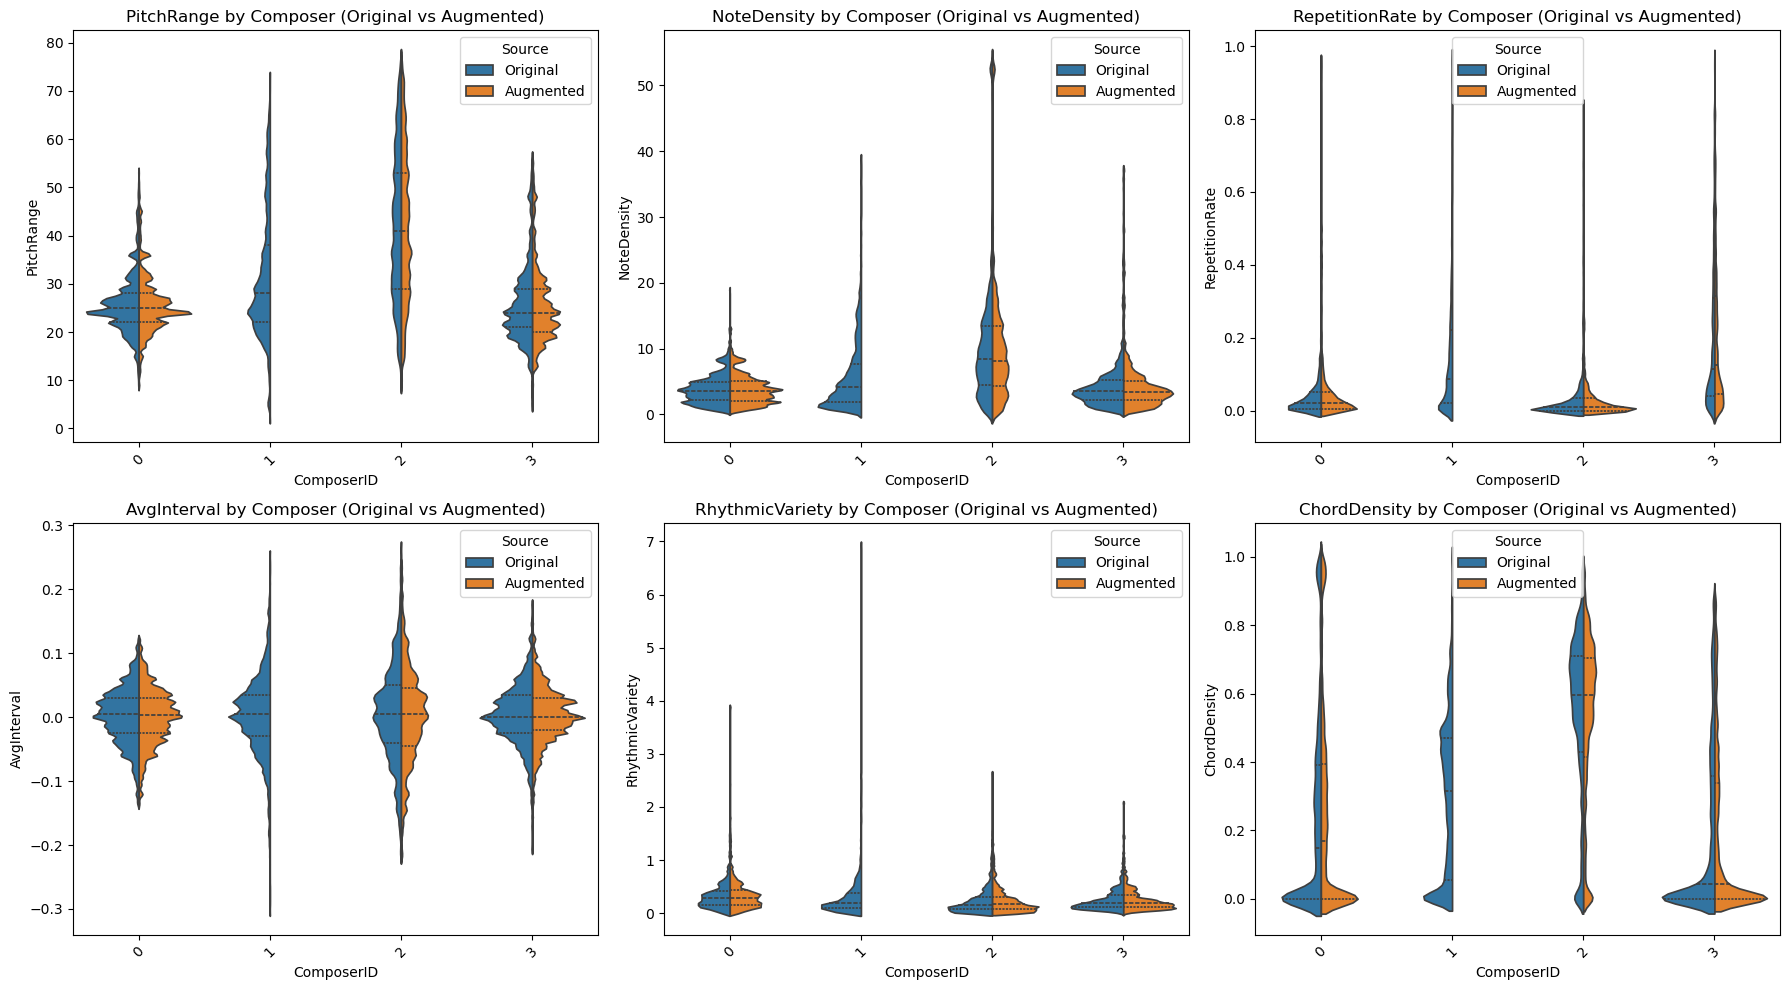

In [ ]:
# piano plots to compare distributions of important features after augmentations
plt.figure(figsize=(18, 10))
for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(data=df_compare, x='ComposerID', y=feat, hue='Source', split=True, inner='quart')
    plt.title(f'{feat} by Composer (Original vs Augmented)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
pca_features = ['Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval',
                'PitchRange', 'NoteDensity', 'RepetitionRate',
                'AvgInterval', 'RhythmicVariety', 'ChordDensity']

### PCA representation of original and augmented data

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop NaNs just in case
df_compare_clean = df_compare.dropna(subset=pca_features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_compare_clean[pca_features])

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to DataFrame
df_compare_clean['PCA1'] = X_pca[:, 0]
df_compare_clean['PCA2'] = X_pca[:, 1]

/tmp/ipykernel_1991/1059013715.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


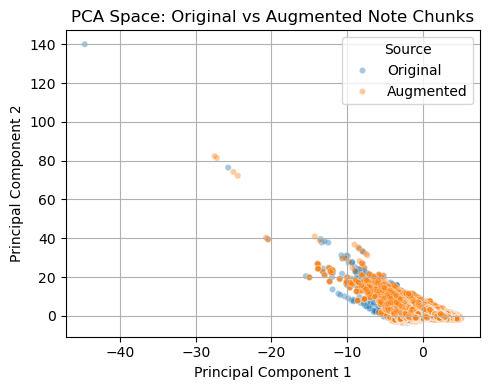

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.scatterplot(data=df_compare_clean, x='PCA1', y='PCA2', hue='Source', alpha=0.4, s=20)
plt.title('PCA Space: Original vs Augmented Note Chunks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

### Removing all correlated features from each dataset.

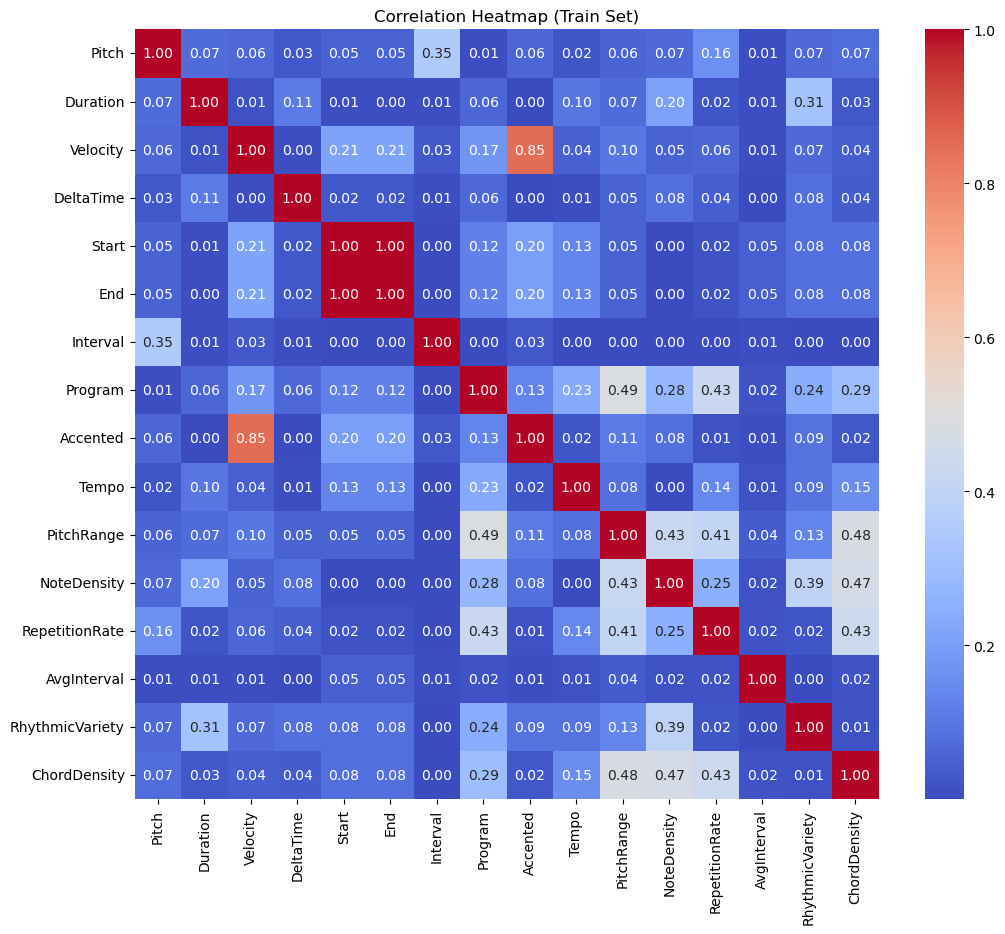

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features only (drop categorical, target columns)
numeric_features = df_train.select_dtypes(include=[np.number]).drop(columns=['ComposerID'])

# Compute correlation matrix
corr_matrix = numeric_features.corr().abs()

# Plot heatmap (optional)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Train Set)")
plt.show()

In [ ]:
# Upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['End']


In [ ]:
df_train_reduced = df_train.drop(columns=to_drop)
df_val_reduced   = df_val.drop(columns=to_drop)
df_test_reduced  = df_test.drop(columns=to_drop)

In [ ]:
# Step 1: Frequency encode 'Program' on the training data only
program_freq = df_train_reduced['Program'].value_counts(normalize=True).to_dict()
df_train_reduced['Program_FE'] = df_train_reduced['Program'].map(program_freq)

# Step 2: Apply the same mapping to val and test datasets
df_val_reduced['Program_FE'] = df_val_reduced['Program'].map(program_freq)
df_test_reduced['Program_FE'] = df_test_reduced['Program'].map(program_freq)

# Step 3: Handle unseen 'Program' values in val/test by replacing with 0
# Fill NaNs safely without chained assignment
df_val_reduced['Program_FE'] = df_val_reduced['Program_FE'].fillna(0)
df_test_reduced['Program_FE'] = df_test_reduced['Program_FE'].fillna(0)

### StandardScaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Define features to scale (exclude label columns like Start and Program)
features_to_scale = [
    'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval', 'Program_FE', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

# 1. Fit scaler only on train balanced data
scaler = StandardScaler()
df_train_scaled = df_train_reduced.copy()
df_train_scaled[features_to_scale] = scaler.fit_transform(df_train_reduced[features_to_scale])

# 2. Apply same scaler to val and test sets
df_val_scaled = df_val.copy()
df_val_scaled[features_to_scale] = scaler.transform(df_val_reduced[features_to_scale])

df_test_scaled = df_test.copy()
df_test_scaled[features_to_scale] = scaler.transform(df_test_reduced[features_to_scale])

In [ ]:
print("Train:", np.unique(df_train_scaled['ComposerID']))
print("Val:  ", np.unique(df_val_scaled['ComposerID']))
print("Test: ", np.unique(df_test_scaled['ComposerID']))

Train: [0 1 2 3]
Val:   [0 1 2 3]
Test:  [0 1 2 3]


### Prepare input sequences for the LSTM implementation

In [ ]:
# Define features to use in LSTM input
lstm_features = [
'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Interval', 'Program_FE', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

CHUNK_SIZE = 100  # Number of notes per LSTM input sequence

def create_lstm_chunks(df, chunk_size=CHUNK_SIZE, label_column='ComposerID'):
    X_chunks = []
    y_chunks = []

    # Group by file or composer if available
    grouped = df.groupby(['ComposerID'])

    for _, group in grouped:
        group = group.sort_values('Start')  # Ensure chronological order
        features = group[lstm_features].values
        labels = group[label_column].values

        # Chunk features and assign label to each chunk
        for i in range(0, len(features) - chunk_size + 1, chunk_size):
            chunk = features[i:i + chunk_size]
            chunk_label = labels[i]  # Take label from first note
            X_chunks.append(chunk)
            y_chunks.append(chunk_label)

    return np.array(X_chunks, dtype=np.float32), np.array(y_chunks, dtype=np.int64)

# Apply to train, val, test
X_train, y_train = create_lstm_chunks(df_train_scaled)
X_val, y_val     = create_lstm_chunks(df_val_scaled)
X_test, y_test   = create_lstm_chunks(df_test_scaled)

# Final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10414, 100, 14)
y_train shape: (10414,)
X_val shape: (2134, 100, 14)
y_val shape: (2134,)
X_test shape: (2238, 100, 14)
y_test shape: (2238,)


### Define plain LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def build_lstm_model(units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(100, 14), num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))     # Avoids warning
    model.add(LSTM(units))                  # Main recurrent layer
    model.add(Dropout(dropout_rate))        # Regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### Perform Grid search on different combinations of parameters

In [ ]:
print("Unique classes in y_test:", np.unique(y_train))
print("Min label:", np.min(y_train), "Max label:", np.max(y_train))
print("Number of classes:", len(np.unique(y_train)))

Unique classes in y_test: [0 1 2 3]
Min label: 0 Max label: 3
Number of classes: 4


In [ ]:
# Define parameter grid
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [64, 128],
    'epochs': [20]
}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import itertools

results = []

for units, dropout_rate, lr, batch_size, epochs in itertools.product(
    param_grid['units'], param_grid['dropout_rate'], 
    param_grid['learning_rate'], param_grid['batch_size'], 
    param_grid['epochs']
):
    print(f"Training model with units={units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")

    model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=lr, num_classes=4)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    results.append({
        'units': units,
        'dropout': dropout_rate,
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': val_acc,
        'history': history.history 
    })

# Sort results by best accuracy
results_df = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)

Training model with units=64, dropout=0.3, lr=0.001, batch_size=64
Training model with units=64, dropout=0.3, lr=0.001, batch_size=128
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=64
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=128
Training model with units=64, dropout=0.5, lr=0.001, batch_size=64
Training model with units=64, dropout=0.5, lr=0.001, batch_size=128
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=64
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=128
Training model with units=128, dropout=0.3, lr=0.001, batch_size=64
Training model with units=128, dropout=0.3, lr=0.001, batch_size=128
Training model with units=128, dropout=0.3, lr=0.0005, batch_size=64
Training model with units=128, dropout=0.3, lr=0.0005, batch_size=128
Training model with units=128, dropout=0.5, lr=0.001, batch_size=64
Training model with units=128, dropout=0.5, lr=0.001, batch_size=128
Training model with units=128, dropout=0.5,

In [ ]:
# Get best result (row with highest val_acc)
best_result = results_df.iloc[0]

print("\n Best Hyperparameters Found:")
print(f"Units        : {best_result['units']}")
print(f"Dropout Rate : {best_result['dropout']}")
print(f"Learning Rate: {best_result['lr']}")
print(f"Batch Size   : {best_result['batch_size']}")
print(f"Val Accuracy : {best_result['val_acc']:.4f}")


 Best Hyperparameters Found:
Units        : 64
Dropout Rate : 0.5
Learning Rate: 0.001
Batch Size   : 128
Val Accuracy : 0.9288


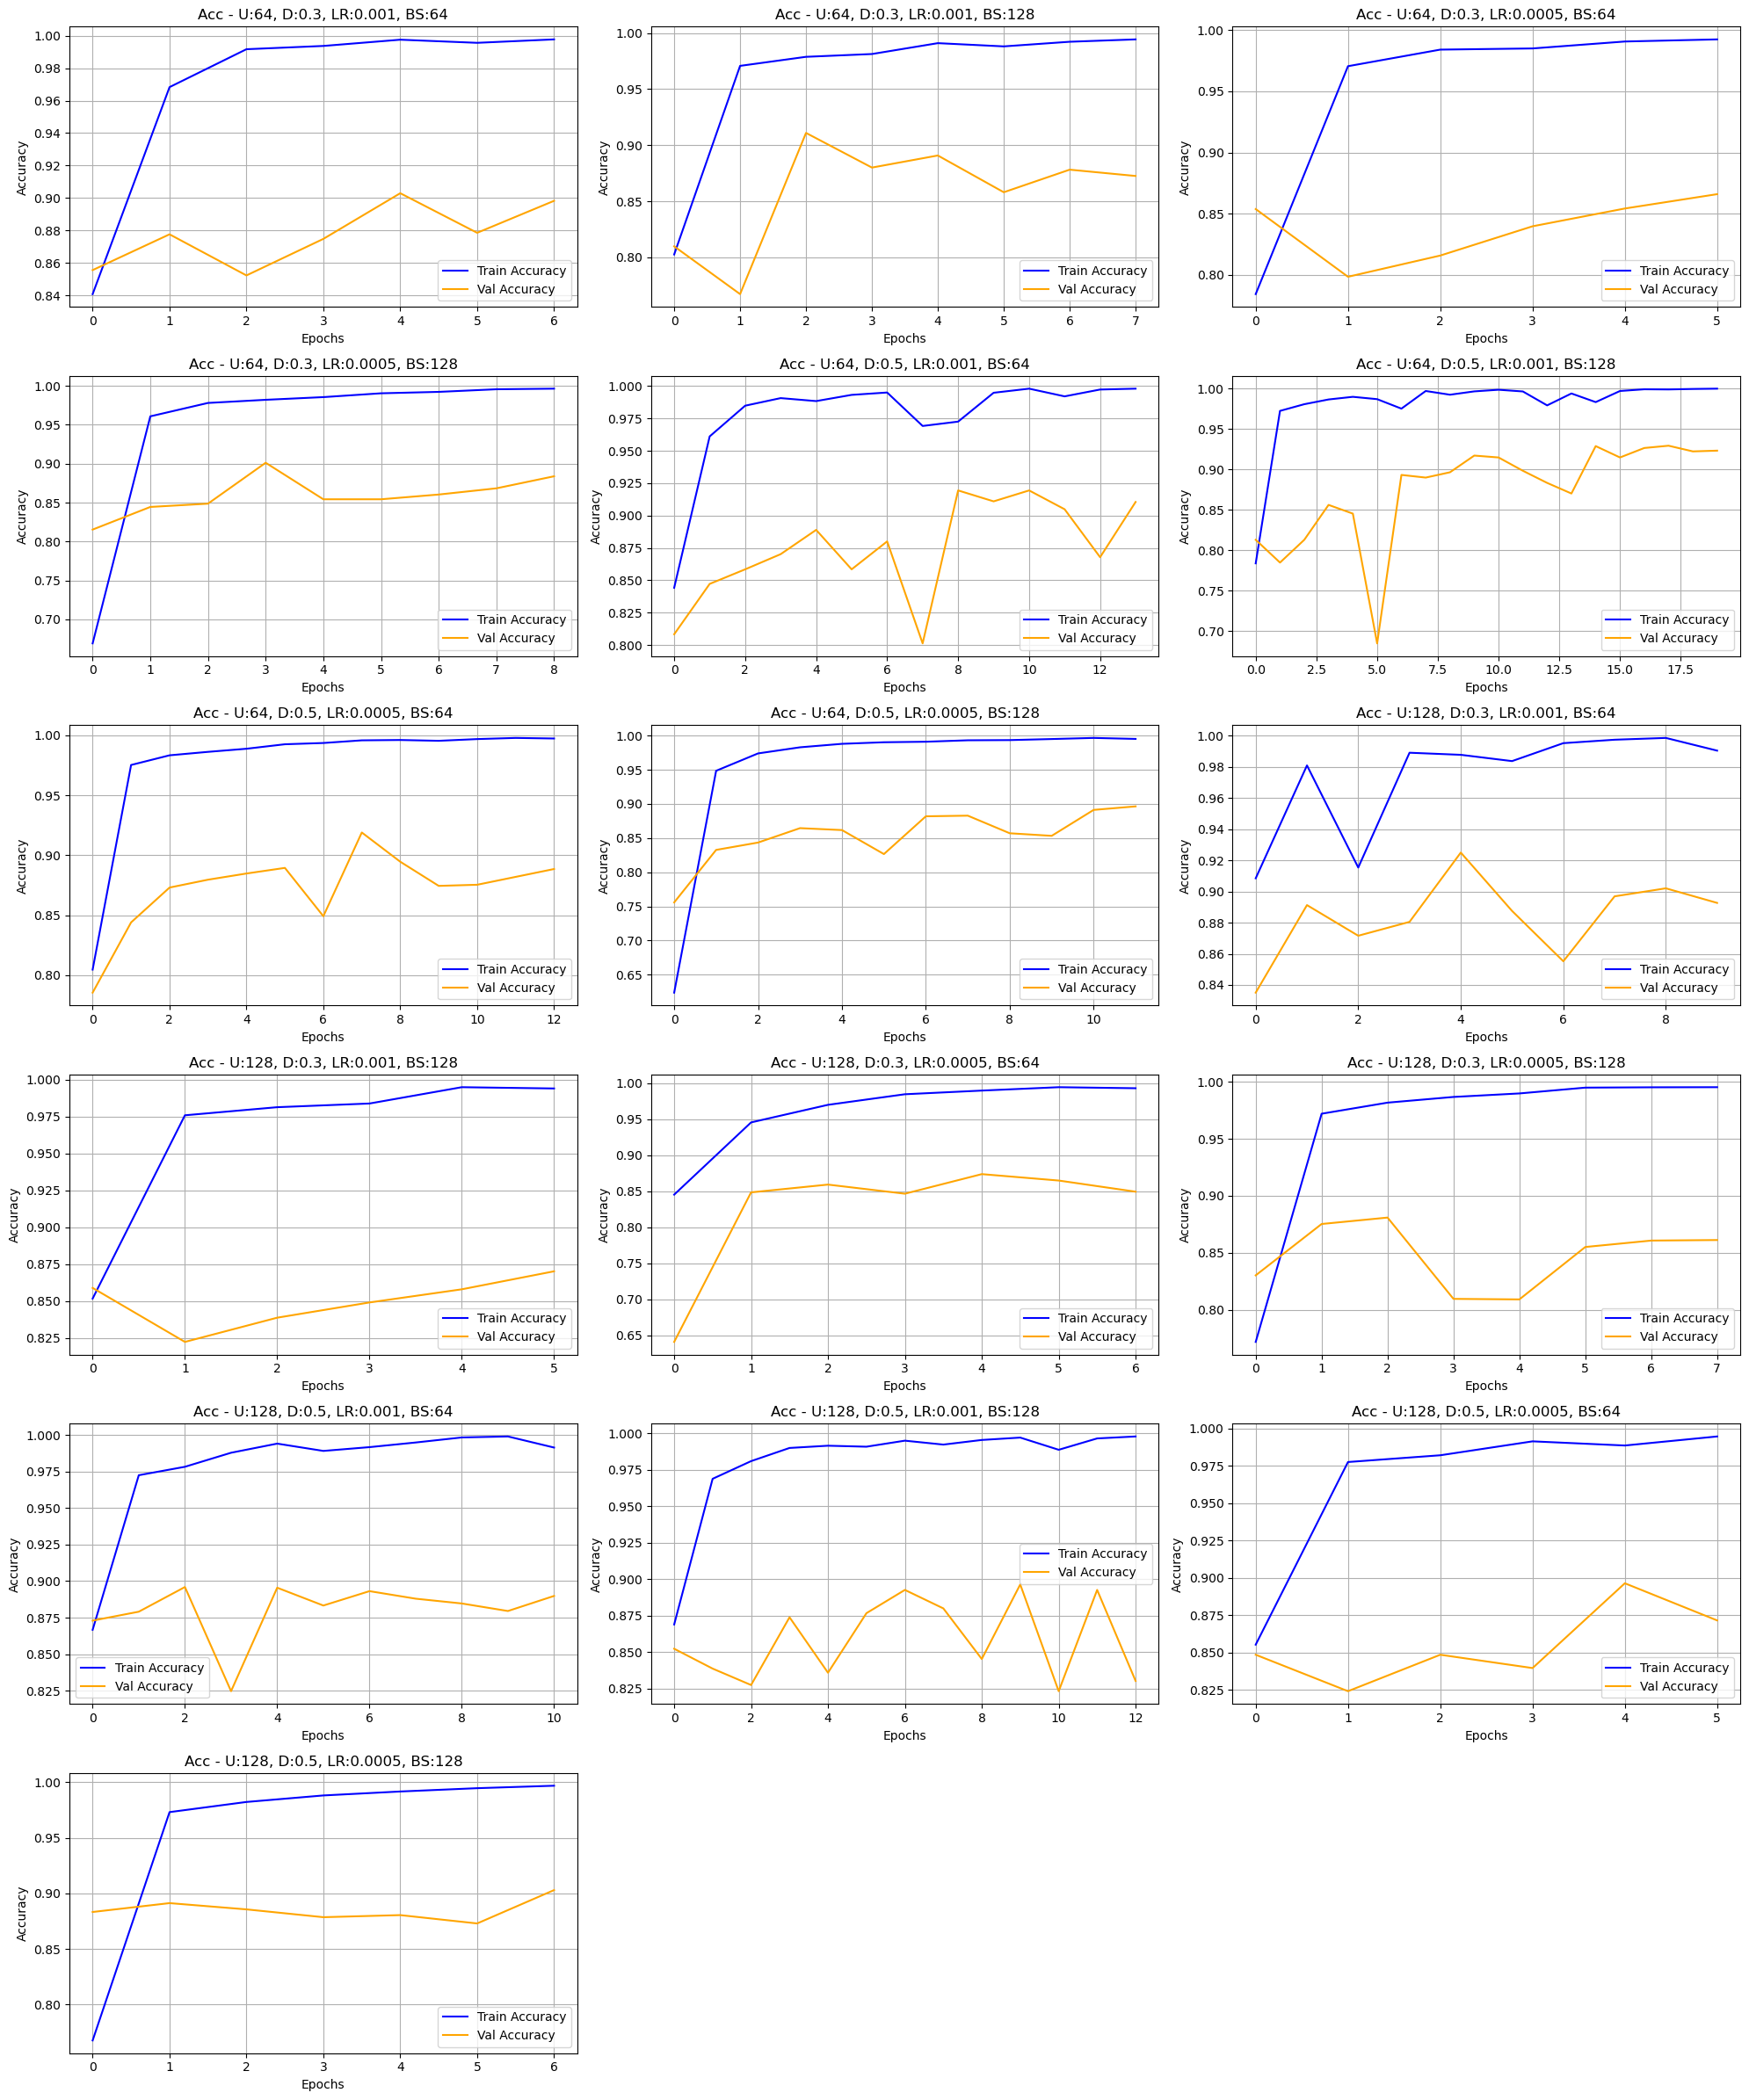

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
num_models = len(results)
cols = 3
rows = (num_models + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))

for i, result in enumerate(results, 1):
    history = result['history']
    
    plt.subplot(rows, cols, i)
    plt.plot(history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Val Accuracy', color='orange')

    plt.title(f"Acc - U:{result['units']}, D:{result['dropout']}, LR:{result['lr']}, BS:{result['batch_size']}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

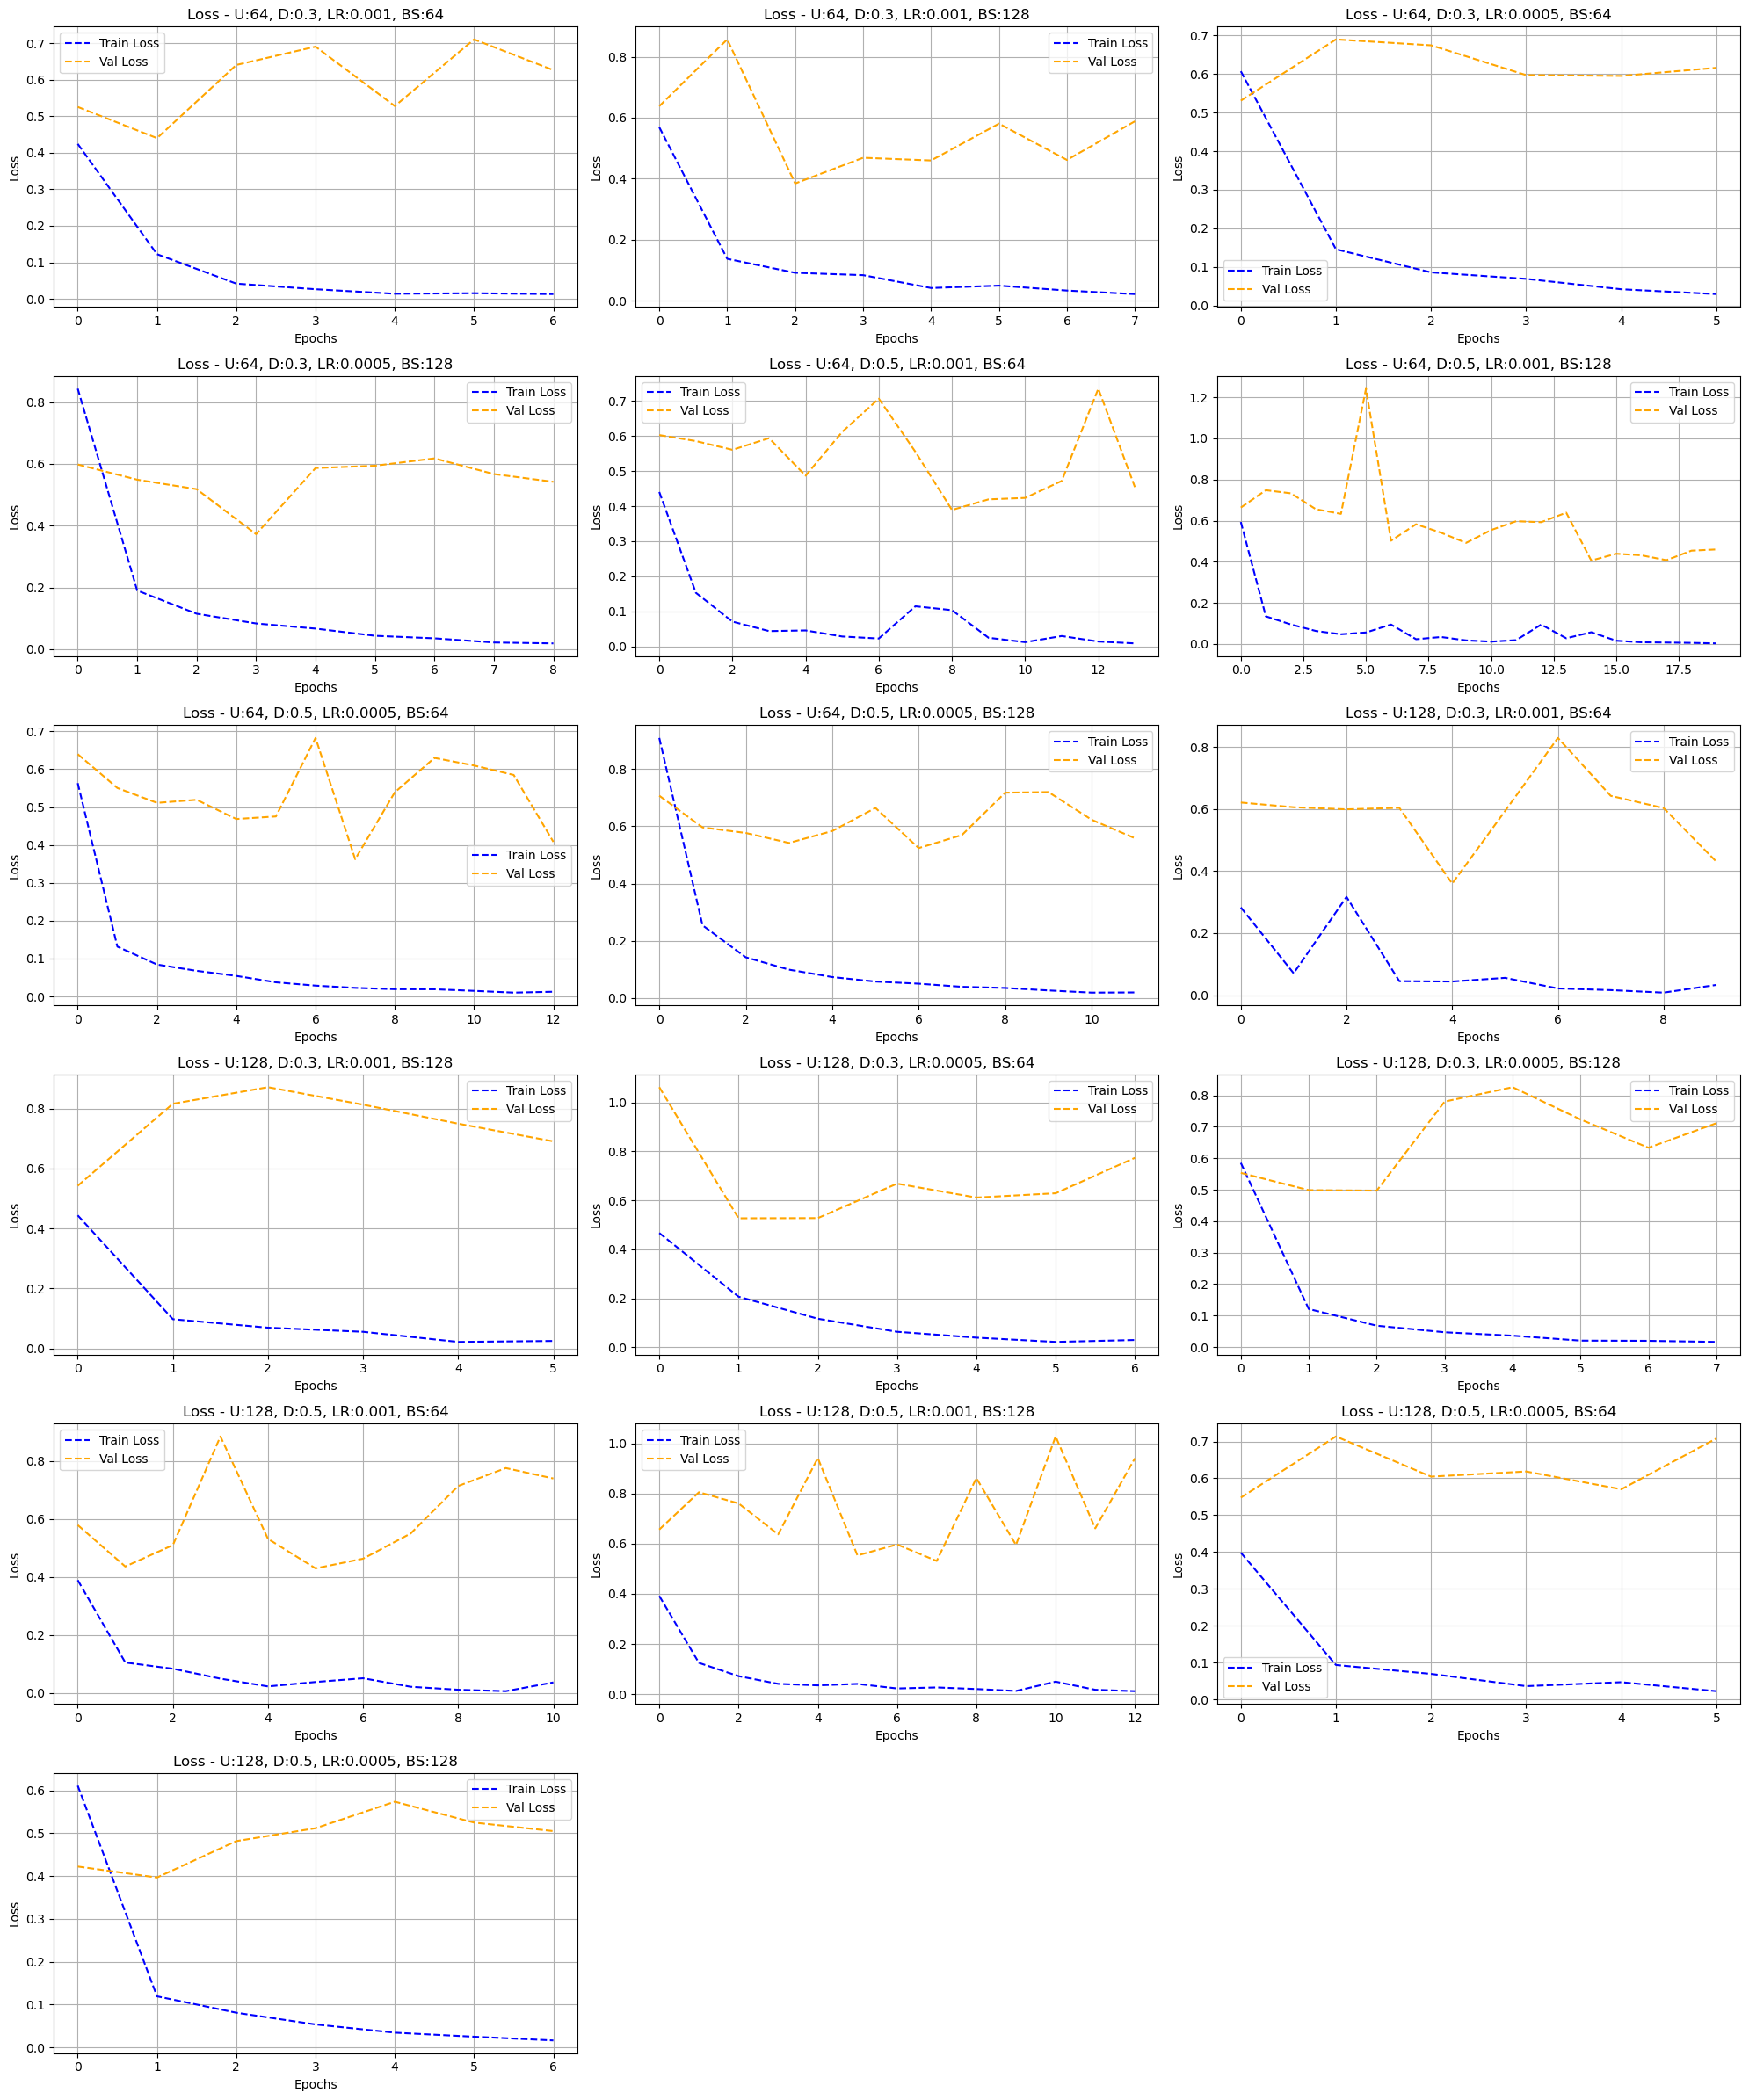

In [ ]:
# Loss Plot
plt.figure(figsize=(20, rows * 4))

for i, result in enumerate(results, 1):
    history = result['history']
    
    plt.subplot(rows, cols, i)
    plt.plot(history['loss'], label='Train Loss', color='blue', linestyle='--')
    plt.plot(history['val_loss'], label='Val Loss', color='orange', linestyle='--')

    plt.title(f"Loss - U:{result['units']}, D:{result['dropout']}, LR:{result['lr']}, BS:{result['batch_size']}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Build and Train Final Model with Best Params
final_model = build_lstm_model(
    units=64,
    dropout_rate=0.5,
    learning_rate=0.001,
    input_shape=(100, 14)
)

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)

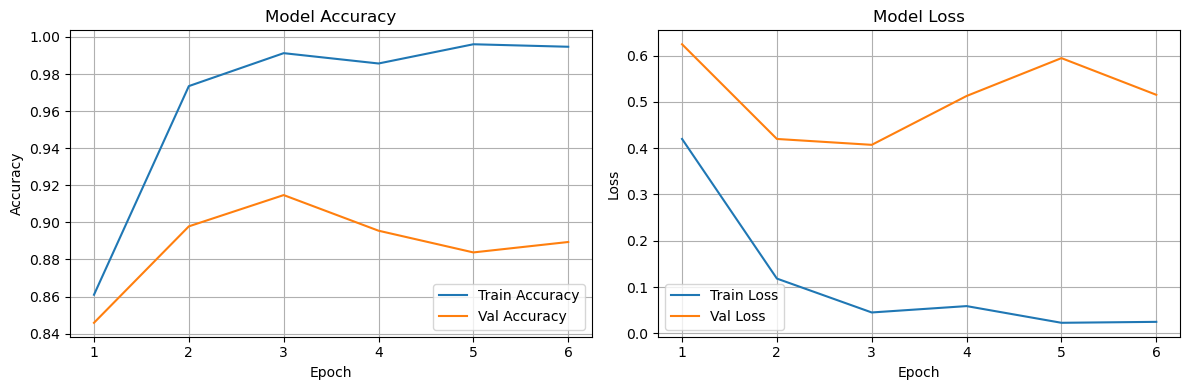

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### MOdel Evaluation on test dataset

In [ ]:
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Accuracy: {test_acc:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9636 - loss: 0.1463
Final Test Accuracy: 0.8561


In [ ]:
# Predictions and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predicted class labels
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report:

              precision    recall  f1-score   support

        Bach       0.83      0.98      0.90       496
   Beethoven       0.91      0.95      0.93       846
      Chopin       0.77      0.98      0.86       440
      Mozart       0.91      0.43      0.59       456

    accuracy                           0.86      2238
   macro avg       0.86      0.83      0.82      2238
weighted avg       0.87      0.86      0.84      2238



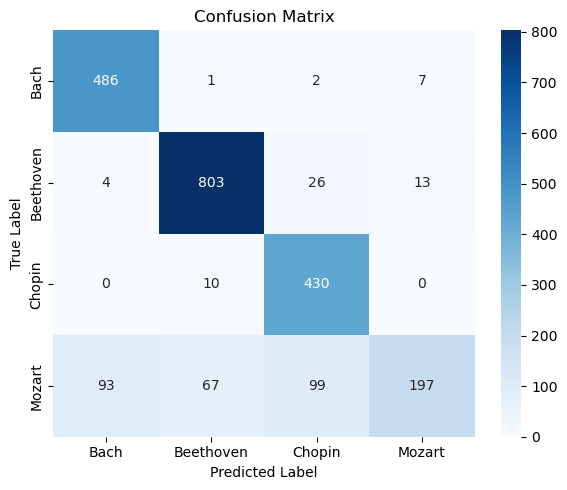

In [ ]:
# Confusion matrix plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

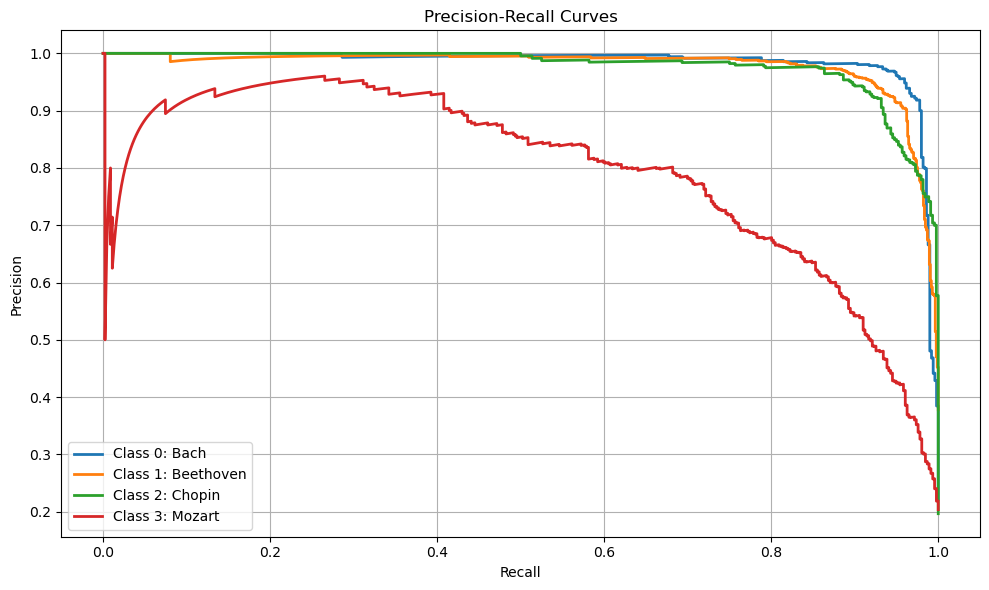

In [ ]:
# Precision-recall curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize labels for multiclass
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}: {composer_list[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

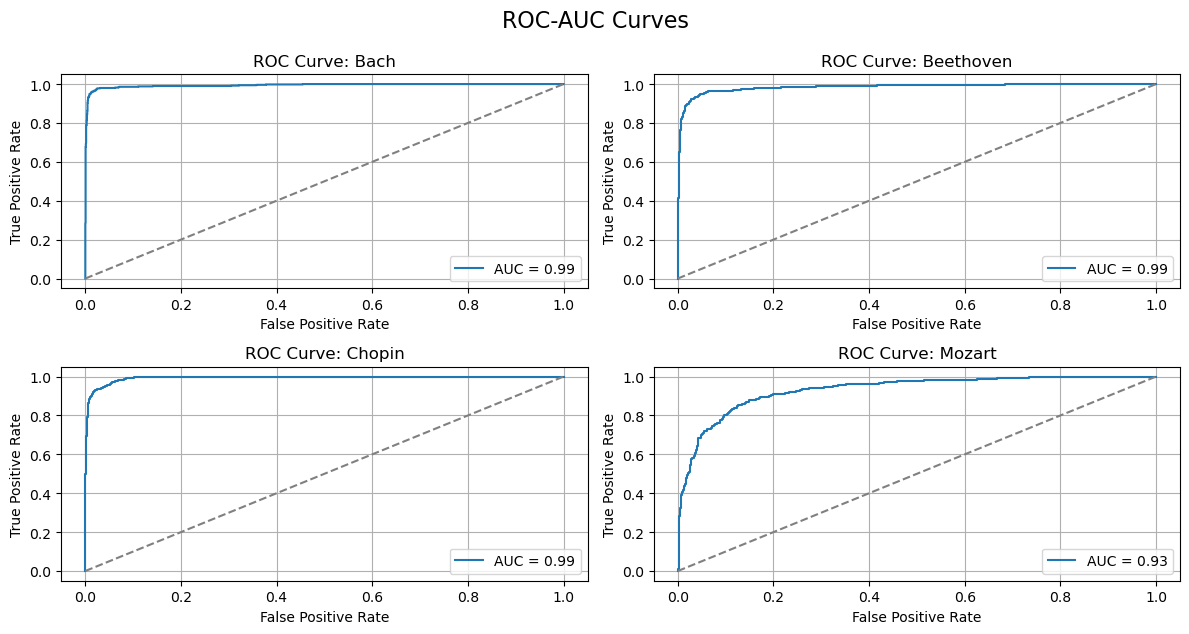

In [ ]:
# Plot ROC-AUC curves for test data evaluated on each class classification task
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("ROC-AUC Curves", fontsize=16, y=1.05)
plt.show()

### Conclusions and Inferences on LSTM model:

Final Test Accuracy

•	Overall accuracy: 85.61%
•	Loss: 0.1463
•	Model trained using early stopping, stopping at 6 epochs.

| **True Class** | **Correctly Classified** | **Major Confusions**                                         |
|----------------|---------------------------|---------------------------------------------------------------|
| **Bach**       | 486 / 496 (98%)           | 7 misclassified as **Mozart**                                 |
| **Beethoven**  | 803 / 846 (95%)           | Some misclassified as **Chopin (26)** and **Mozart (13)**     |
| **Chopin**     | 430 / 440 (98%)           | Few misclassified as **Beethoven (10)**                       |
| **Mozart**     | 197 / 456 (43%)           | Heavily misclassified as **Chopin (99)**, **Bach (93)**, and **Beethoven (67)** |

Mozart is the most confused class, likely due to:

•	Underrepresentation in learned features

•	Musical similarity in style to other composers

•	Insufficient unique features after augmentation

| **Class**    | **Precision** | **Recall** | **F1-Score** | **Support** |
|--------------|---------------|------------|--------------|-------------|
| **Bach**     | 0.83          | 0.98       | 0.90         | 496         |
| **Beethoven**| 0.91          | 0.95       | 0.93         | 846         |
| **Chopin**   | 0.77          | 0.98       | 0.86         | 440         |
| **Mozart**   | 0.91          | 0.43       | 0.59         | 456         |
|              |               |            |              |             |
| **Accuracy** |               |            | **0.86**     | 2238        |
| **Macro Avg**| 0.86          | 0.83       | 0.82         | 2238        |
| **Weighted Avg**| 0.87       | 0.86       | 0.84         | 2238        |


•	High Recall (0.98) for Bach and Chopin --> model rarely misses their true examples

•	Low Recall (0.43) for Mozart --> model misses a majority of true Mozart samples

•	Precision is good overall, but Chopin has relatively lower precision (more false positives)

Macro Avg F1-Score = 0.82

Weighted Avg F1-Score = 0.84

Model Accuracy and Loss Curves


•	Training Accuracy nearly reaches 99%

•	Validation Accuracy peaks at ~91% at Epoch 3 but then slightly drops

•	Training Loss drops steadily and remains low

•	Validation Loss increases slightly after Epoch 3 --> signs of overfitting

Precision-Recall Curve Observations


•	Bach, Beethoven, Chopin: High area under PR curve --> good balance between precision and recall

•	Mozart (red line): Poor PR curve — drops quickly in both precision and recall at various thresholds --> class imbalance or feature overlap issues

•	AUC scores indicate excellent separability for all except Mozart

•	Mozart’s ROC AUC = 0.93 --> Still decent, but not as separable as others


### Takeaways

1.	Excellent performance on Bach, Beethoven, and Chopin.

2.	Mozart remains challenging:

•	Highest confusion

•	Lowest recall & F1-score

•	PR and ROC curves show lower confidence and separability

3.	Slight overfitting visible after Epoch 3. Consider:

•	Early stopping at lower epochs

•	Slightly higher dropout (e.g., 0.6)

•	Adding regularization (L2) or batch normalization

4.	Data Augmentation/Feature Engineering for Mozart is critical.

•	Consider chord density, rhythm patterns, or interval histograms as additional features

5.	Current LSTM performs well with tuned hyperparameters, but a BiLSTM with attention might generalize better with class context.




### Implementation of Bidirectional LSTM + attention mechanism to improve the performance of the model

In [90]:
# import additional libraries required for bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# sklearn libraries required
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [ ]:
# Define attention layer
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = inputs * a
        return K.sum(output, axis=1)

In [ ]:
# Define Bidirectional LSTM with attention mechanism

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_bilstm_attention_model(units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(100, 14), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Define hypermeters for grid search
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [30]  
}

In [ ]:
# Perform model trainings for different grid search parameters defined
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import pandas as pd

results_bilstm = []

for units, dropout_rate, lr, batch_size, epochs in itertools.product(
    param_grid['units'], param_grid['dropout_rate'], 
    param_grid['learning_rate'], param_grid['batch_size'], 
    param_grid['epochs']
):
    print(f"Training model: units={units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")

    model = build_bilstm_attention_model(
        units=units, dropout_rate=dropout_rate,
        learning_rate=lr, input_shape=(100, 14), num_classes=4
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    results_bilstm.append({
        'units': units,
        'dropout': dropout_rate,
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'history': history.history
    })

Training model: units=64, dropout=0.3, lr=0.001, batch_size=32
Training model: units=64, dropout=0.3, lr=0.001, batch_size=64
Training model: units=64, dropout=0.3, lr=0.0005, batch_size=32
Training model: units=64, dropout=0.3, lr=0.0005, batch_size=64
Training model: units=64, dropout=0.5, lr=0.001, batch_size=32
Training model: units=64, dropout=0.5, lr=0.001, batch_size=64
Training model: units=64, dropout=0.5, lr=0.0005, batch_size=32
Training model: units=64, dropout=0.5, lr=0.0005, batch_size=64
Training model: units=128, dropout=0.3, lr=0.001, batch_size=32
Training model: units=128, dropout=0.3, lr=0.001, batch_size=64
Training model: units=128, dropout=0.3, lr=0.0005, batch_size=32
Training model: units=128, dropout=0.3, lr=0.0005, batch_size=64
Training model: units=128, dropout=0.5, lr=0.001, batch_size=32
Training model: units=128, dropout=0.5, lr=0.001, batch_size=64
Training model: units=128, dropout=0.5, lr=0.0005, batch_size=32
Training model: units=128, dropout=0.5, l

In [ ]:
# Fetch the best models from the grid search

results_df = pd.DataFrame(results_bilstm).sort_values(by='val_acc', ascending=False)
print("Top performing parameter sets:")
display(results_df.head(3))

Top performing parameter sets:


,units,dropout,lr,batch_size,val_acc,val_loss,history
4,64,0.5,0.0010,32,0.937676,0.325717,"{'accuracy': [0.959861695766449, 0.99471867084..."
8,128,0.3,0.0010,32,0.929241,0.366057,"{'accuracy': [0.9628384709358215, 0.9930862188..."
14,128,0.5,0.0005,32,0.922212,0.402079,"{'accuracy': [0.9517956376075745, 0.9910697340..."


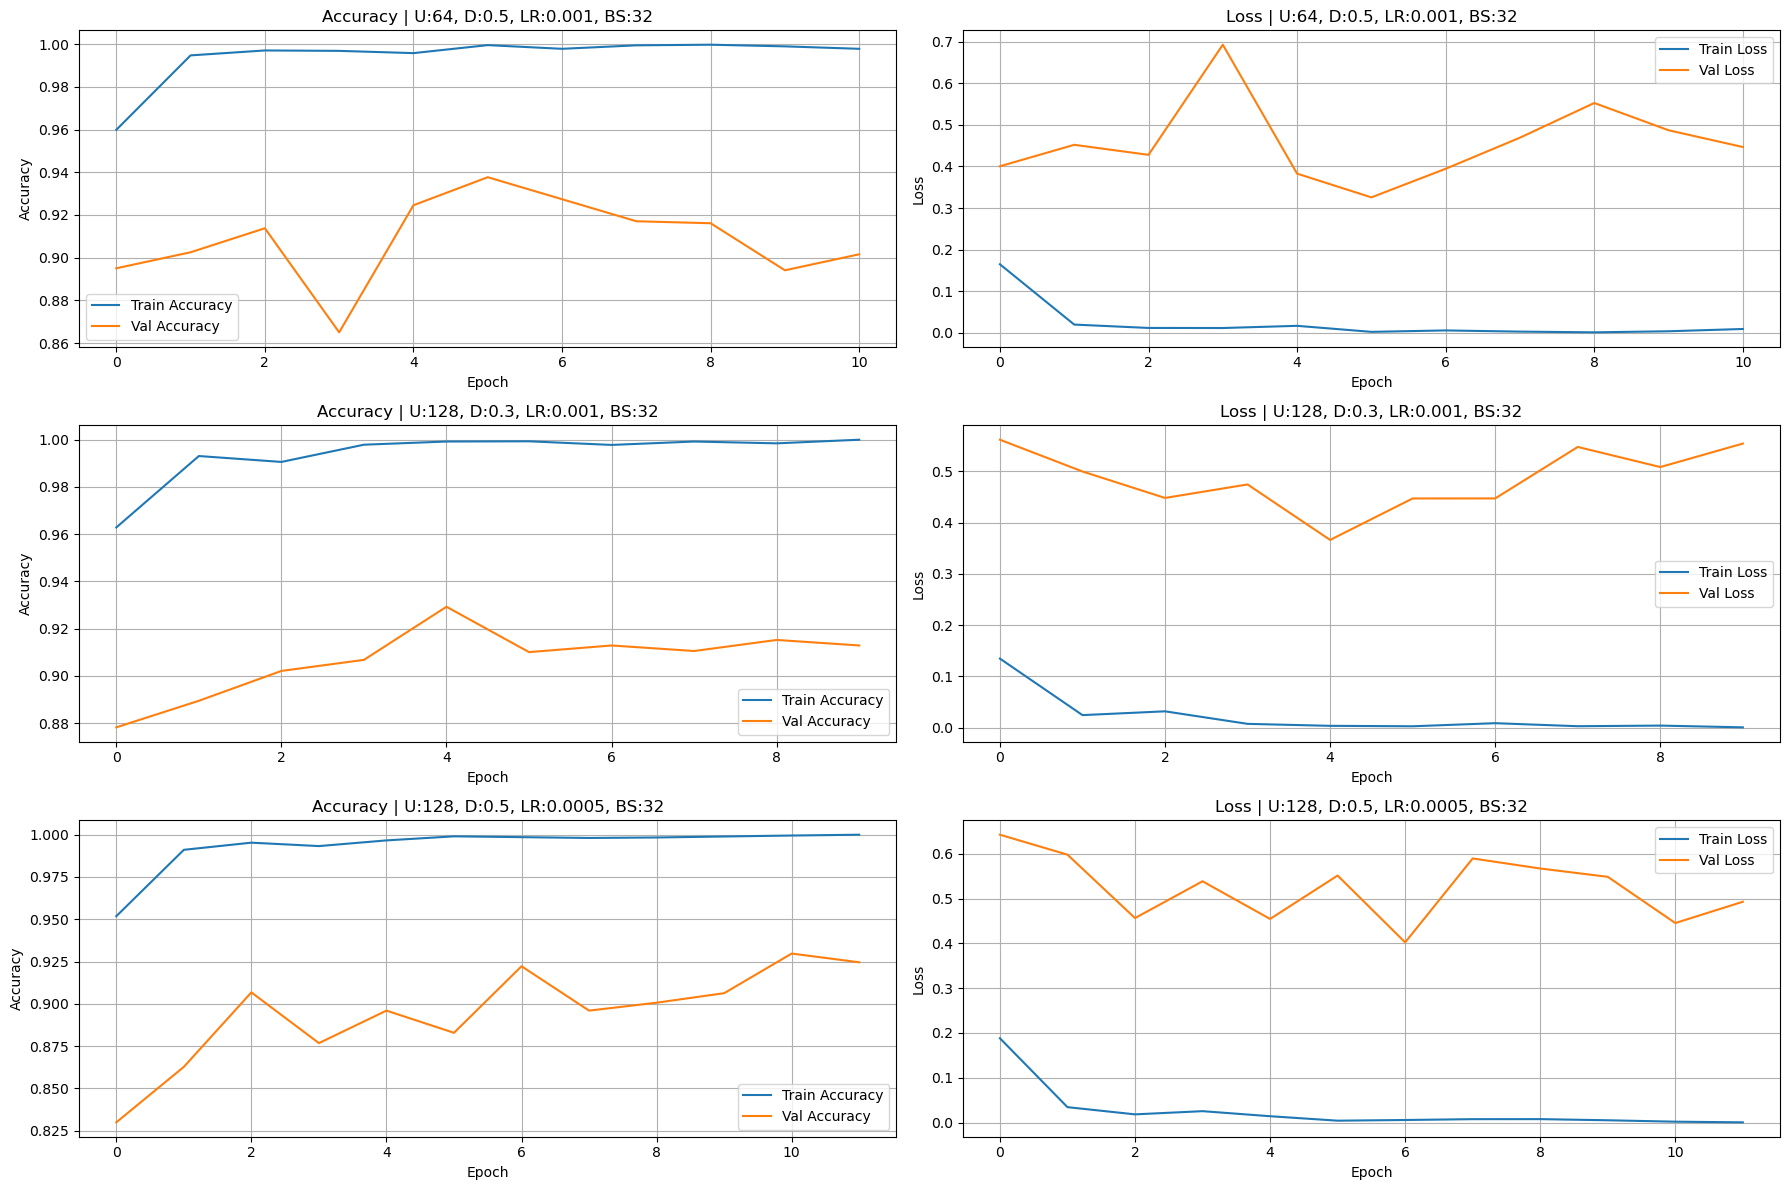

In [ ]:
import matplotlib.pyplot as plt

top_k = 3
plt.figure(figsize=(18, top_k * 4))

# Plot the train and val accuracy and loss curves of top 3 models best performed
for i, result in enumerate(results_df.head(top_k).itertuples(), 1):
    history = result.history
    plt.subplot(top_k, 2, 2*i - 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy | U:{result.units}, D:{result.dropout}, LR:{result.lr}, BS:{result.batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(top_k, 2, 2*i)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Loss | U:{result.units}, D:{result.dropout}, LR:{result.lr}, BS:{result.batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Model Evaluation on Test set with Bidirectional LSTM + attention with the best model hyperparameters

In [ ]:
# Now choose the best model and also model that can avoid overfitting as well

bilstm_att_model = build_bilstm_attention_model(
    units=128,
    dropout_rate=0.5,
    learning_rate=0.0005,
    input_shape=(100, 14),num_classes=4
)

history_att = bilstm_att_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

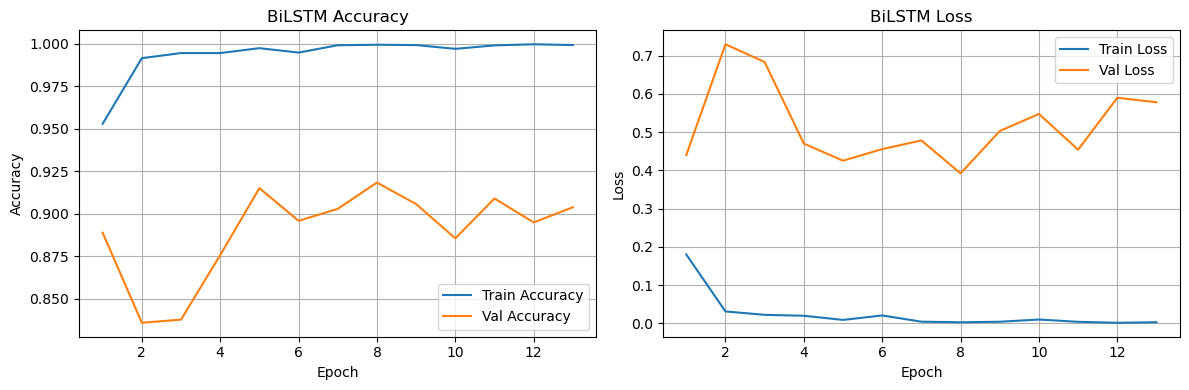

In [99]:
# Extract accuracy and loss from history
acc_bi = history_att.history['accuracy']
val_acc_bi = history_att.history['val_accuracy']
loss_bi = history_att.history['loss']
val_loss_bi = history_att.history['val_loss']
epochs_range_bi = range(1, len(acc_bi) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_bi, acc_bi, label='Train Accuracy')
plt.plot(epochs_range_bi, val_acc_bi, label='Val Accuracy')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_bi, loss_bi, label='Train Loss')
plt.plot(epochs_range_bi, val_loss_bi, label='Val Loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### BILSTM+ attention Model evaluation on test dataset 

In [ ]:
test_loss_bilstm, test_acc_bilstm = bilstm_att_model.evaluate(X_test, y_test, verbose=1)
print(f"BiLSTM Test Accuracy: {test_acc_bilstm:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9800 - loss: 0.0749
BiLSTM Test Accuracy: 0.9294


#### Classification report and confusion matrix for evaluating bidirectional LSTM + aatention model

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
BiLSTM Classification Report:

              precision    recall  f1-score   support

        Bach       0.92      0.98      0.95       496
   Beethoven       0.97      0.97      0.97       846
      Chopin       0.86      0.99      0.92       440
      Mozart       0.96      0.74      0.84       456

    accuracy                           0.93      2238
   macro avg       0.93      0.92      0.92      2238
weighted avg       0.93      0.93      0.93      2238



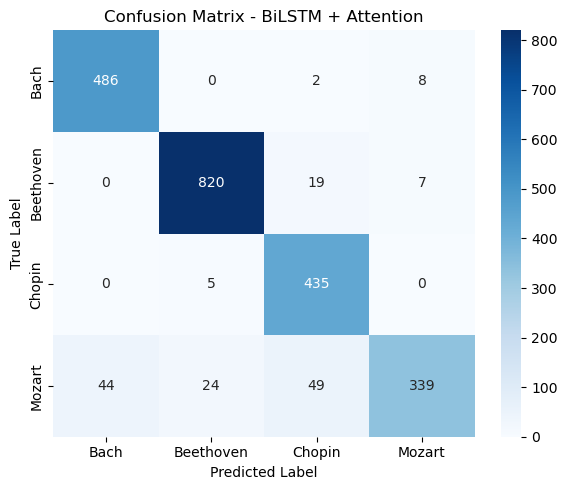

In [105]:
# Predict class probabilities and convert to labels
y_pred_probs = bilstm_att_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("BiLSTM Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=composer_list))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=composer_list,
            yticklabels=composer_list)
plt.title("Confusion Matrix - BiLSTM + Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Binarize ground truth
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#### Plot Precision-recall curves for the best model for visualization

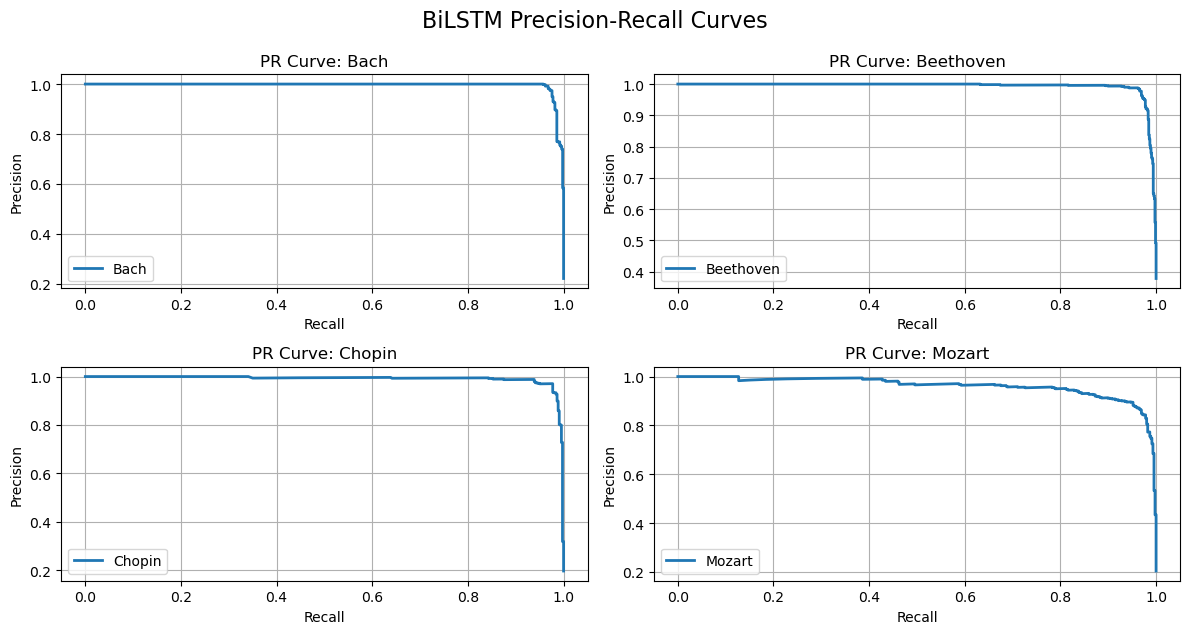

In [106]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.subplot(2, 2, i + 1)
    plt.plot(recall, precision, label=f'{composer_list[i]}', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("BiLSTM Precision-Recall Curves", fontsize=16, y=1.05)
plt.show()

#### Plot ROC-AUC for bidirectional LSTM + attention - best model overall

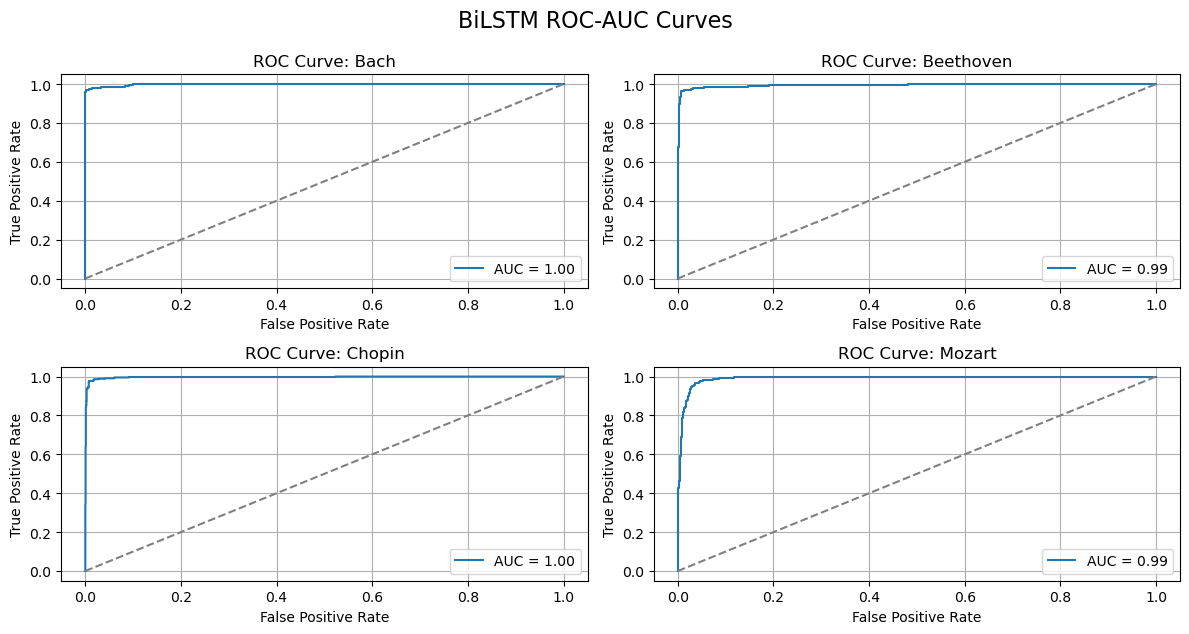

In [107]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {composer_list[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("BiLSTM ROC-AUC Curves", fontsize=16, y=1.05)
plt.show()

#### Saving the model for deployment purpose or re-evaluation purpose

In [104]:
# Save plain LSTM model
final_model.save("final_lstm_model.keras")
print(" Saved LSTM model as lstm_model.keras")

# Save BiLSTM + Attention model
bilstm_att_model.save("final_bi_lstm_attention_model.keras")
print(" Saved BiLSTM + Attention model as bilstm_attention_model.keras")

 Saved LSTM model as lstm_model.keras
 Saved BiLSTM + Attention model as bilstm_attention_model.keras


### Conclusions and Inferences on BiLSTM=Attention model

**Model Performance Summary – BiLSTM + Attention**

| **Metric**            | **Value**                                      |
|-----------------------|------------------------------------------------|
| Test Accuracy         | 92.94%                                         |
| Test Loss             | 0.0749                                         |
| Best Hyperparameters  | units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(100, 14) |

**Observations from Evaluation Plots**

1. Accuracy & Loss Trends (Train vs Validation)

•	Training Accuracy reaches almost perfect, indicating strong learning capability.

•	Validation Accuracy stabilizes around 91%, slightly lower than training — shows mild overfitting.

•	Validation Loss fluctuates slightly across epochs, but generally decreasing.

Inference:

Model is learning well, but regularization (e.g., higher dropout, early stopping) can further reduce overfitting.

**Classification report**

| **Class**     | **Precision** | **Recall** | **F1-Score** | **Support** |
|---------------|---------------|------------|--------------|-------------|
| Bach          | 0.92          | 0.98       | 0.95         | 496         |
| Beethoven     | 0.97          | 0.97       | 0.97         | 846         |
| Chopin        | 0.86          | 0.99       | 0.92         | 440         |
| Mozart        | 0.96          | 0.74       | 0.84         | 456         |
| **Accuracy**  |               |            | **0.93**     | **2238**    |
| **Macro Avg** | 0.93          | 0.92       | 0.92         | 2238        |
| **Weighted Avg** | 0.93       | 0.93       | 0.93         | 2238        |


**Confusion matrix analysis**

| **True Class** | **Correctly Classified** | **Major Confusions**                    |
|----------------|--------------------------|-----------------------------------------|
| Bach           | 486 / 496 (97%)          | 8 → Mozart                              |
| Beethoven      | 820 / 846 (97%)          | 19 → Chopin, 7 → Mozart                 |
| Chopin         | 435 / 440 (97%)          | 5 → Beethoven                           |
| Mozart         | 339 / 456 (74%)          | 44 → Bach, 49 → Chopin, 24 → Beethoven  |

Inference:

*	Bach, Beethoven, and Chopin are well classified (>97%).

*	Mozart is most confused, especially with stylistically similar composers like Chopin and Bach.

**Precision-Recall (PR) Curves**

*	All classes have high PR curves, showing strong precision-recall trade-off.

*	Mozart’s PR curve is slightly lower — due to lower recall and class confusion.

ROC-AUC Curves

*	All classes show excellent AUC scores (≥ 0.97).

*	Mozart has slightly lower but still strong AUC 






### Comparision report analysis of BiLSTM + Attention and LSTM models

Here’s a detailed comparison between the LSTM and BiLSTM + Attention models based on your confusion matrices, performance metrics, and key observations:

**Overall Performance Comparison Table:**

| **Metric**               | **LSTM Model** | **BiLSTM + Attention Model** |
|--------------------------|----------------|-------------------------------|
| **Test Accuracy**        | 85.61%         | 92.94%                        |
| **Test Loss**            | 0.1463         | 0.0749                        |
| **Macro Avg Precision**  | 0.86           | 0.93                          |
| **Macro Avg Recall**     | 0.83           | 0.92                          |
| **Macro Avg F1-Score**   | 0.82           | 0.92                          |
| **Weighted Avg F1-Score**| 0.84           | 0.93                          |


**Confusion matrix comparision:**

| **Class**   | **LSTM**             | **BiLSTM + Attention**  |
|-------------|----------------------|--------------------------|
| **Bach**     | 486 / 496 (98%)      | 486 / 496 (98%)          |
| **Beethoven**| 803 / 846 (95%)      | 820 / 846 (97%)          |
| **Chopin**   | 430 / 440 (98%)      | 435 / 440 (98%)          |
| **Mozart**   | 197 / 456 (43%)      | 339 / 456 (74%)          |


**Major Confusions**


*	LSTM misclassified Mozart heavily into Chopin (99), Bach (93), and Beethoven (67).

*	BiLSTM reduced this significantly, showing better distinction in Mozart class.

Interpretation and Insights

Improvements Observed in BiLSTM:

*	Higher Accuracy (+7.3%) over LSTM due to better sequence modeling.

*	Lower Test Loss shows better generalization and stability.

*	Significant boost in Mozart classification (from 43% to 74%), which was previously most problematic.

*	Higher Recall and F1-Score for all classes, especially Mozart and Beethoven.

*	ROC-AUC and PR curves show sharper separation and precision-recall tradeoff for BiLSTM.


**Why BiLSTM + Attention Outperforms LSTM:**

| **Reason**                   | **Explanation**                                                                                         |
|-----------------------------|---------------------------------------------------------------------------------------------------------|
| **Bidirectional Context**    | BiLSTM processes sequences from both past and future, enabling richer temporal understanding, especially important in music (e.g., motifs, harmonics). |
| **Attention Mechanism**      | Focuses on important timesteps in the sequence, helping the model capture critical patterns (e.g., cadence, tempo shift). |
| **Better Generalization**    | Despite higher training accuracy, validation metrics are stable, indicating less overfitting and robust learning. |
| **Improved Mozart Disambiguation** | Mozart’s style may share overlap with others, and attention helps resolve ambiguity better by highlighting distinctive note sequences. |


***Conclusion:***

The BiLSTM + Attention model significantly outperforms the vanilla LSTM model across all evaluation metrics, particularly in handling difficult cases like Mozart. The combination of bidirectional flow of information and attention-based focus leads to deeper sequence understanding and improved composer classification.


